# Exploratory Data Analysis - covariants
by __Pawel Rosikiewicz__ 

---

## Setup
---

__global imports__
* I purposely placed other imports, such as my custom made functions for thsi project in each section
* to allow you fast inspection of my code, but also, copying these important to new notebooks, for pipeline development

In [44]:
import os
import sys
import re # module to use regular expressions, 
import glob # lists names in folders that match Unix shell patterns
import warnings
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn import set_config
from sklearn.preprocessing import RobustScaler # creates custom transfomers
from sklearn.preprocessing import FunctionTransformer # creates custom transfomers
from sklearn.pipeline import make_pipeline, Pipeline # like pipeline function, but give step names automatically, 
from sklearn.compose import ColumnTransformer # allows using different transformers to different columns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer # skleanr transformers,
from sklearn.decomposition import PCA

In [2]:
# basedir
basedir = os.path.dirname(os.getcwd())
os.chdir(basedir)
sys.path.append(basedir)

In [3]:
# paths
PATH_data_raw     = os.path.join(basedir, "data/raw")
PATH_data_interim = os.path.join(basedir, "data/interim")
PATH_results      = os.path.join(basedir, "data/results")
PATH_models       = os.path.join(basedir, "models")

__load functions, and classes created for that project__

In [4]:
from src.utils.helper_data_loaders import load_tsv
from src.utils.PREPROCESSING_PIPELINE01 import data_preprocessing_pipeline

__configurations__

In [5]:
# main variable groups, and types
VAR_GROUPS = dict(
    TARGET_VAR = ["target"],
    CATEGORICAL_VAR = [ 'Baseline ECOG Score', 'Enrollment IC', 'IC Level', 'TC Level', 'Immune phenotype', 'Sex',
           'TCGA Subtype', 'Lund', 'Lund2', 'Received platinum',
           'Met Disease Status', 'Sample age', 'Sample collected pre-platinum',
           'Intravesical BCG administered', 'Tobacco Use History'],
    QUANTITATIVE_VAR = ['FMOne mutation burden per MB', 'Neoantigen burden per MB'],
)

# variable encoding in data_cov
VAR_DTYPES = {
    "TARGET_VAR": "int", # only for EDA
    "CATEGORICAL_VAR": "O",
    "QUANTITATIVE_VAR": "float64"
}

# target variable encoding
TARGET_ENCODING = {0:"non-responder", 1:"responder"}

# list potential confounding variables, used to stratify the results
CONFOUNDING_VAR = ['Sex', 'Tobacco Use History']

## PART 1. Load the data

In [6]:
# load target data
data_cov =  load_tsv(PATH_data_raw, 'X_covariates.tsv')
data_genes = load_tsv(PATH_data_raw, 'X_genes.tsv')
data_cov_test =  load_tsv(PATH_data_raw, 'X_covariates_test.tsv')
data_genes_test = load_tsv(PATH_data_raw, 'X_genes_test.tsv')
target = load_tsv(PATH_data_raw, 'y.tsv', header=None)

# small correction
target.columns=[VAR_GROUPS["TARGET_VAR"][0]]
target = pd.Series(target.iloc[:,0])

(200, 17)
(200, 31085)
(98, 17)
(98, 31085)
(200, 1)


In [7]:
# inspect
print("shape:", data_genes.shape)
print("missing data nr:", data_genes.isnull().sum().sum())

# get example
data_genes.head()

shape: (200, 31085)
missing data nr: 0


TPM_hugo_A1BG  TPM_hugo_A1BG-AS1  TPM_hugo_A1CF  TPM_hugo_A2M  \
0       1.564289           2.711834            0.0    599.387994   
1       3.487859           1.717013            0.0    222.711937   
2       0.613334           0.508520            0.0    204.222937   
3       2.385017           1.600782            0.0   1851.589619   
4       1.964353           0.791064            0.0    982.752783   

   TPM_hugo_A2M-AS1  TPM_hugo_A2ML1  TPM_hugo_A2MP1  TPM_hugo_A3GALT2  \
0          2.354073       43.245808             0.0          0.000000   
1          2.288359        5.718716             0.0          0.564476   
2          0.627338      300.472716             0.0          0.000000   
3          3.301540        1.346349             0.0          0.000000   
4          0.589165       85.088254             0.0          0.096887   

   TPM_hugo_A4GALT  TPM_hugo_A4GNT  ...  TPM_hugo_ZWILCH  TPM_hugo_ZWINT  \
0        11.437090        0.070903  ...         8.574489        6.467672   
1         6.026609        0.108688  ...        10.409939        3.572365   
2        11.797474        0.040773  ...         6.272013        3.109443   
3        23.938826        0.000000  ...         4.586123        1.150169   
4        17.058419        0.447727  ...         4.292896        2.469881   

   TPM_hugo_ZXDA  TPM_hugo_ZXDB  TPM_hugo_ZXDC  TPM_hugo_ZYG11A  \
0       1.906227       3.293924       8.333586         2.189232   
1       2.761780       3.411667       9.293182         1.813353   
2       1.068439       2.559726       5.181549         0.225283   
3       1.464567       1.386418       4.501980         0.036808   
4       1.809374       3.056738       6.604204         0.436553   

   TPM_hugo_ZYG11B  TPM_hugo_ZYX  TPM_hugo_ZZEF1  TPM_hugo_ZZZ3  
0        19.280571    168.266220       27.175332      17.836860  
1        21.761841     66.403339       21.311923      22.296492  
2        15.800051    172.944084       14.743828      18.920023  
3        11.444219    116.271619       19.222790      11.936066  
4        20.036719    143.793153       24.820985      17.297542  

[5 rows x 31085 columns]

In [8]:
# input data
df = data_cov.copy()

# inputs
numeric_features = VAR_GROUPS["QUANTITATIVE_VAR"].copy()

# find all other features in input data
all_other_features = df.columns.values.tolist()
for v in numeric_features:
    try:
        all_other_features.remove(v)
    except:
        pass
    
# create custom transformer
log_scale_transformer = make_pipeline( 
    FunctionTransformer(np.abs, validate=False),   
    FunctionTransformer(np.log1p, validate=False), # creates runtime warning if negative data are used
    StandardScaler()
)

# create data preprocessor for numeric features
numeric_transformer = Pipeline(steps=[
        ("imputer",SimpleImputer(strategy='mean')), 
        ("scaler",StandardScaler())
    ])

# create data preprocessor for numeric features
categorical_transformer = Pipeline(steps=[
        ("first_imputer",SimpleImputer(strategy='most_frequent')),
        ("onehot", OneHotEncoder(handle_unknown='ignore')), 
    ]) # drop='first', 
    # comment: you can drop first and ignore new, following: 
    # .. https://scikit-learn.org/stable/developers/advanced_installation.html

# preprocessor for all the data
''' ColumnTransformer: it allows apllying different tranfomers to different columns
    - give unique names for each transformer
    - passthrough - keyword, nothing is done with that column
    - column names are always provided as LIST
'''
preprocessor = make_pipeline(
    ColumnTransformer(
        transformers = [
            ("numeric_features", numeric_transformer, numeric_features),
            ("other_features", categorical_transformer, all_other_features), # "passthrough" other option,     
        ], 
        remainder='drop'
    ))

# check if everythign is ok
set_config(display="diagram") # or "text"
preprocessor

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric_features',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['FMOne mutation burden per '
                                                   'MB',
                                                   'Neoantigen burden per MB']),
                                                 ('other_features',
                                                  Pipeline(steps=[('first_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Enrollment IC', 'IC Level',
                                                   'TC Level',
                                                   'Immune phenotype', 'Sex',
                                                   'TCGA Subtype', 'Lund',
                                                   'Lund2', 'Received platinum',
                                                   'Met Disease Status',
                                                   'Sample age',
                                                   'Sample collected '
                                                   'pre-platinum',
                                                   'Intravesical BCG '
                                                   'administered',
                                                   'Baseline ECOG Score',
                                                   'Tobacco Use History'])]))])

In [9]:
# test
eg = preprocessor.fit_transform(data_cov.iloc[0:40, :])
eg2 = preprocessor.transform(data_cov_test)

print(eg.shape, eg2.shape)

(40, 50) (98, 50)


In [10]:
# parameters for data preparation
parameters = {
    'Signif_genes':{
        'zv_filter_dct':dict(na_tr=0.5),
        'sp_filter_dct':dict(tr=0.95, quantile=True),
        'select_genes_dct':dict(Log2FCtr=0.5, Ptr=0.05, create_plot=True),
        'pca_n_components':0
     },
    'Signif_genes_PCA':{
        'zv_filter_dct':dict(na_tr=0.5),
        'sp_filter_dct':dict(tr=0.95, quantile=True),
        'select_genes_dct':dict(Log2FCtr=0.5, Ptr=0.05, create_plot=True),
        'pca_n_components':None
     },    
    'DE_genes_PCA':{
        'zv_filter_dct':dict(na_tr=0.5),
        'sp_filter_dct':dict(tr=0.95, quantile=True),
        'select_genes_dct':dict(Log2FCtr=0.2, Ptr=0.2, create_plot=True),
        'pca_n_components':None
     }    
}

In [18]:
def merge_data(df1, df2, verbose=True):
    ''' vhelper function to join info in two dataframes, prepared in notebook 03
        in two planned dataset one of them will be missing, 
    '''
    df1 = pd.DataFrame(df1)
    df2 = pd.DataFrame(df2)
    
    # check dimensions
    if verbose==True: 
        print("df1 shape: ", df1.shape)    
        print("df2 shape: ", df2.shape)    
    
    # ensure there is no reindexing
    df1.reset_index(inplace=True, drop=True)
    df2.reset_index(inplace=True, drop=True)
    
    # merge
    if df1 is not None and df2 is not None:
        final_dataset = pd.concat([df1, df2], axis=1)                                
    if df1 is not None and df2 is None:
        final_dataset = df1.copy()   
    if df1 is None and df2 is not None:
        final_dataset = df2.copy()
    
    # check final dimensions
    if verbose==True: 
        print("final df: ", final_dataset.shape)    
    else: 
        pass
    
    return final_dataset.values

40
160


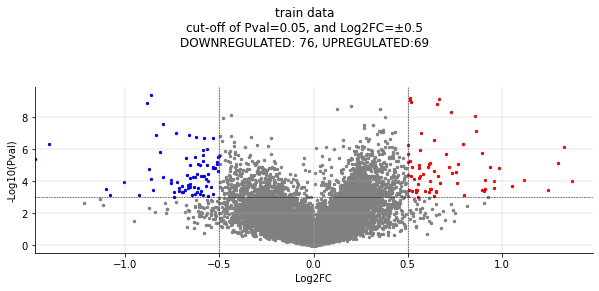


............................................................
 train - Step 1-5
............................................................



input    log  \
sample nr                                              160    160   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.4   
mean tpm value recorded                               32.2    1.8   
max tpm value recorded                            314419.1   18.3   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 60.0%  60.0%   
% of genes not expressed in any sample               18.3%  18.3%   
% of genes expressed in at least 50%  of samples     59.4%  59.4%   
% of genes expressed in all samples                  43.8%  43.8%   

                                                 log_filtered  \
sample nr                                                 160   
gene nr                                                 18475   
- VALUES -                                                      
min tpm value recorded                                    0.0   
median tpm value recorded                                 2.9   
mean tpm value recorded                                   3.1   
max tpm value recorded                                   18.3   
- DETECTED IN -                                                 
mean % of genes expressed per sample                    95.9%   
% of genes not expressed in any sample                   0.0%   
% of genes expressed in at least 50%  of samples       100.0%   
% of genes expressed in all samples                     73.7%   

                                                 log_filtered_scaled  \
sample nr                                                        160   
gene nr                                                        18475   
- VALUES -                                                             
min tpm value recorded                                          -9.2   
median tpm value recorded                                       -0.0   
mean tpm value recorded                                          0.1   
max tpm value recorded                                         328.3   
- DETECTED IN -                                                        
mean % of genes expressed per sample                          100.0%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples              100.0%   
% of genes expressed in all samples                           100.0%   

                                                 outliers_removed top_genes  \
sample nr                                                     152       152   
gene nr                                                     18475       145   
- VALUES -                                                                    
min tpm value recorded                                       -9.2      -3.9   
median tpm value recorded                                    -0.0      -0.0   
mean tpm value recorded                                       0.1       0.1   
max tpm value recorded                                      328.3      45.5   
- DETECTED IN -                                                               
mean % of genes expressed per sample                       100.0%    100.0%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples           100.0%    100.0%   
% of genes expressed in all samples                        100.0%    100.0%   

                                                 after pca  
sample nr                                              152  
gene nr                                                145  
- VALUES -                                                  
min tpm value recorded                                -3.9  
median tpm value recorded              

............................................................
SIMILARITY BEWEEN SAMPLES
BASED ON GENE EXPRESSION IN THE TOP 145 
differencially expressed genes
............................................................


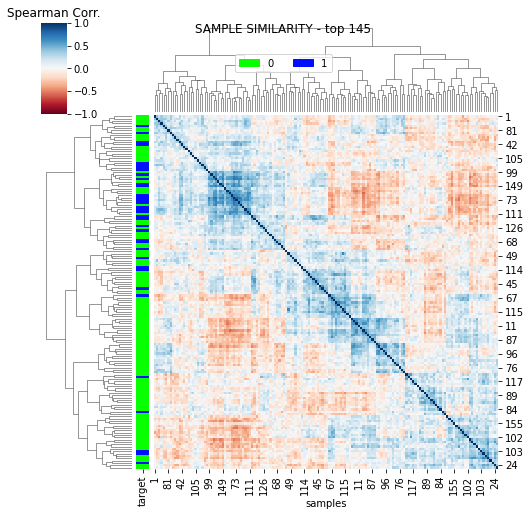

............................................................
GENE EXPRESSION IN THE TOP 
 145 differencially expressed genes
............................................................


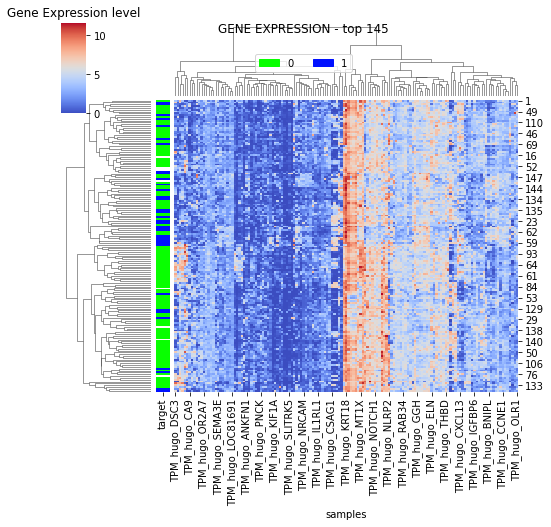

............................................................
PCA and tSNE analysis
............................................................


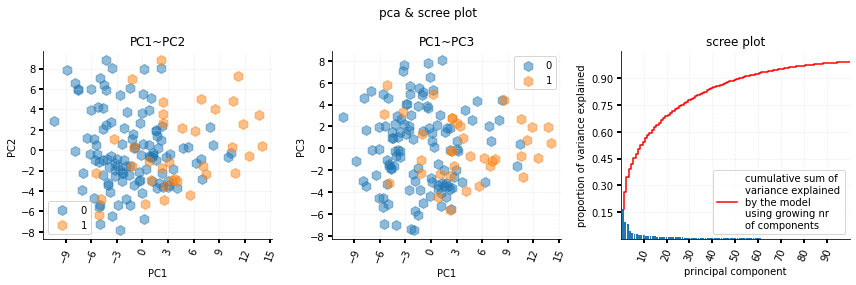


............................................................
 test0 - Step 1-5
............................................................



input    log log_filtered  \
sample nr                                              40     40           40   
gene nr                                             31085  31085        18475   
- VALUES -                                                                      
min tpm value recorded                                0.0    0.0          0.0   
median tpm value recorded                             0.3    0.4          2.9   
mean tpm value recorded                              32.2    1.8          3.1   
max tpm value recorded                            98876.1   16.6         16.6   
- DETECTED IN -                                                                 
mean % of genes expressed per sample                60.4%  60.4%        96.3%   
% of genes not expressed in any sample              22.7%  22.7%         0.0%   
% of genes expressed in at least 50%  of samples    60.1%  60.1%        99.5%   
% of genes expressed in all samples                 47.7%  47.7%        80.3%   

                                                 log_filtered_scaled  \
sample nr                                                         40   
gene nr                                                        18475   
- VALUES -                                                             
min tpm value recorded                                          -6.0   
median tpm value recorded                                       -0.0   
mean tpm value recorded                                          0.1   
max tpm value recorded                                         128.4   
- DETECTED IN -                                                        
mean % of genes expressed per sample                          100.0%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples              100.0%   
% of genes expressed in all samples                           100.0%   

                                                 outliers_removed top_genes  \
sample nr                                                      40        40   
gene nr                                                     18475       145   
- VALUES -                                                                    
min tpm value recorded                                       -6.0      -3.3   
median tpm value recorded                                    -0.0       0.0   
mean tpm value recorded                                       0.1       0.1   
max tpm value recorded                                      128.4      31.7   
- DETECTED IN -                                                               
mean % of genes expressed per sample                       100.0%    100.0%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples           100.0%    100.0%   
% of genes expressed in all samples                        100.0%    100.0%   

                                                 after pca  
sample nr                                               40  
gene nr                                                145  
- VALUES -                                                  
min tpm value recorded                                -3.3  
median tpm value recorded                              0.0  
mean tpm value recorded                                0.1  
max tpm value recorded                                31.7  
- DETECTED IN -                                             
mean % of genes expressed per sample                100.0%  
% of genes not expressed in any sample                0.0%  
% of genes expressed in at least 50%  of samples    100.0%  
% of genes expressed in all samples                 100.0%


............................................................
 test1 - Step 1-5
............................................................



input    log  \
sample nr                                               98     98   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.4   
mean tpm value recorded                               32.2    1.8   
max tpm value recorded                            133685.0   17.0   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 60.4%  60.4%   
% of genes not expressed in any sample               19.6%  19.6%   
% of genes expressed in at least 50%  of samples     60.0%  60.0%   
% of genes expressed in all samples                  45.6%  45.6%   

                                                 log_filtered  \
sample nr                                                  98   
gene nr                                                 18475   
- VALUES -                                                      
min tpm value recorded                                    0.0   
median tpm value recorded                                 2.9   
mean tpm value recorded                                   3.1   
max tpm value recorded                                   17.0   
- DETECTED IN -                                                 
mean % of genes expressed per sample                    96.2%   
% of genes not expressed in any sample                   0.0%   
% of genes expressed in at least 50%  of samples        99.6%   
% of genes expressed in all samples                     76.7%   

                                                 log_filtered_scaled  \
sample nr                                                         98   
gene nr                                                        18475   
- VALUES -                                                             
min tpm value recorded                                          -6.8   
median tpm value recorded                                        0.0   
mean tpm value recorded                                          0.1   
max tpm value recorded                                         149.5   
- DETECTED IN -                                                        
mean % of genes expressed per sample                          100.0%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples              100.0%   
% of genes expressed in all samples                           100.0%   

                                                 outliers_removed top_genes  \
sample nr                                                      98        98   
gene nr                                                     18475       145   
- VALUES -                                                                    
min tpm value recorded                                       -6.8      -3.2   
median tpm value recorded                                     0.0       0.0   
mean tpm value recorded                                       0.1       0.1   
max tpm value recorded                                      149.5      33.3   
- DETECTED IN -                                                               
mean % of genes expressed per sample                       100.0%    100.0%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples           100.0%    100.0%   
% of genes expressed in all samples                        100.0%    100.0%   

                                                 after pca  
sample nr                                               98  
gene nr                                                145  
- VALUES -                                                  
min tpm value recorded                                -3.2  
median tpm value recorded              



----------------------------------------

train data ...
df1 shape:  (152, 145)
df2 shape:  (152, 50)
final df:  (152, 195)

validation data ...
df1 shape:  (40, 145)
df2 shape:  (40, 50)
final df:  (40, 195)

test data ...
df1 shape:  (98, 145)
df2 shape:  (98, 50)
final df:  (98, 195)
----------------------------------------


PWD:  /Users/pawel/Desktop/activities/100__Projects/Ardigen/Ardigen/data/interim
SAVED:  Signif_genes_v1__transf_data_dct.p
SAVED:  Signif_genes_v1__qc_reports_dct.p


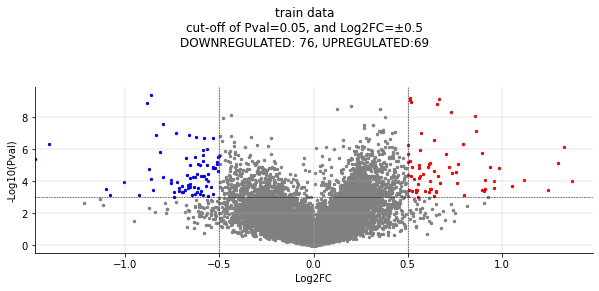


............................................................
 train - Step 1-5
............................................................



input    log  \
sample nr                                              160    160   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.4   
mean tpm value recorded                               32.2    1.8   
max tpm value recorded                            314419.1   18.3   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 60.0%  60.0%   
% of genes not expressed in any sample               18.3%  18.3%   
% of genes expressed in at least 50%  of samples     59.4%  59.4%   
% of genes expressed in all samples                  43.8%  43.8%   

                                                 log_filtered  \
sample nr                                                 160   
gene nr                                                 18475   
- VALUES -                                                      
min tpm value recorded                                    0.0   
median tpm value recorded                                 2.9   
mean tpm value recorded                                   3.1   
max tpm value recorded                                   18.3   
- DETECTED IN -                                                 
mean % of genes expressed per sample                    95.9%   
% of genes not expressed in any sample                   0.0%   
% of genes expressed in at least 50%  of samples       100.0%   
% of genes expressed in all samples                     73.7%   

                                                 log_filtered_scaled  \
sample nr                                                        160   
gene nr                                                        18475   
- VALUES -                                                             
min tpm value recorded                                          -9.2   
median tpm value recorded                                       -0.0   
mean tpm value recorded                                          0.1   
max tpm value recorded                                         328.3   
- DETECTED IN -                                                        
mean % of genes expressed per sample                          100.0%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples              100.0%   
% of genes expressed in all samples                           100.0%   

                                                 outliers_removed top_genes  \
sample nr                                                     152       152   
gene nr                                                     18475       145   
- VALUES -                                                                    
min tpm value recorded                                       -9.2      -3.9   
median tpm value recorded                                    -0.0      -0.0   
mean tpm value recorded                                       0.1       0.1   
max tpm value recorded                                      328.3      45.5   
- DETECTED IN -                                                               
mean % of genes expressed per sample                       100.0%    100.0%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples           100.0%    100.0%   
% of genes expressed in all samples                        100.0%    100.0%   

                                                 after pca  
sample nr                                              152  
gene nr                                                145  
- VALUES -                                                  
min tpm value recorded                               -12.0  
median tpm value recorded              

............................................................
SIMILARITY BEWEEN SAMPLES
BASED ON GENE EXPRESSION IN THE TOP 145 
differencially expressed genes
............................................................


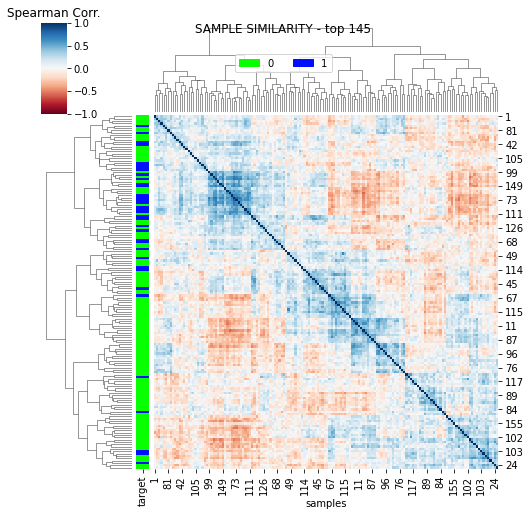

............................................................
GENE EXPRESSION IN THE TOP 
 145 differencially expressed genes
............................................................


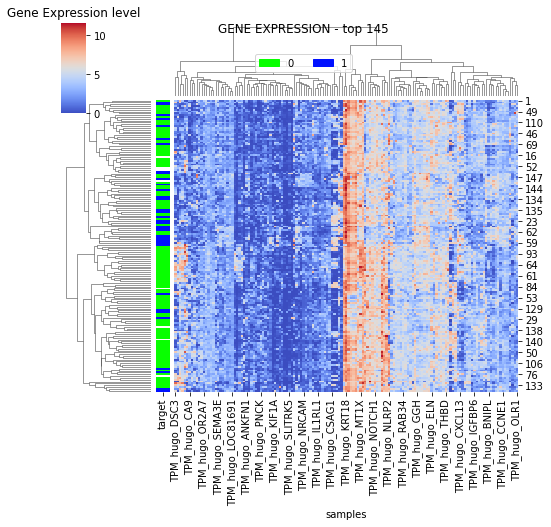

............................................................
PCA and tSNE analysis
............................................................


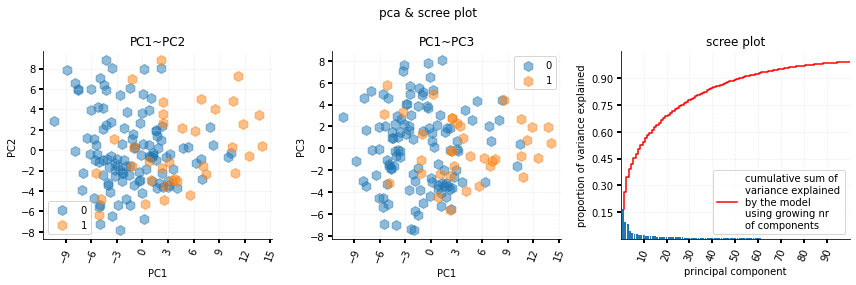


............................................................
 test0 - Step 1-5
............................................................



input    log log_filtered  \
sample nr                                              40     40           40   
gene nr                                             31085  31085        18475   
- VALUES -                                                                      
min tpm value recorded                                0.0    0.0          0.0   
median tpm value recorded                             0.3    0.4          2.9   
mean tpm value recorded                              32.2    1.8          3.1   
max tpm value recorded                            98876.1   16.6         16.6   
- DETECTED IN -                                                                 
mean % of genes expressed per sample                60.4%  60.4%        96.3%   
% of genes not expressed in any sample              22.7%  22.7%         0.0%   
% of genes expressed in at least 50%  of samples    60.1%  60.1%        99.5%   
% of genes expressed in all samples                 47.7%  47.7%        80.3%   

                                                 log_filtered_scaled  \
sample nr                                                         40   
gene nr                                                        18475   
- VALUES -                                                             
min tpm value recorded                                          -6.0   
median tpm value recorded                                       -0.0   
mean tpm value recorded                                          0.1   
max tpm value recorded                                         128.4   
- DETECTED IN -                                                        
mean % of genes expressed per sample                          100.0%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples              100.0%   
% of genes expressed in all samples                           100.0%   

                                                 outliers_removed top_genes  \
sample nr                                                      40        40   
gene nr                                                     18475       145   
- VALUES -                                                                    
min tpm value recorded                                       -6.0      -3.3   
median tpm value recorded                                    -0.0       0.0   
mean tpm value recorded                                       0.1       0.1   
max tpm value recorded                                      128.4      31.7   
- DETECTED IN -                                                               
mean % of genes expressed per sample                       100.0%    100.0%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples           100.0%    100.0%   
% of genes expressed in all samples                        100.0%    100.0%   

                                                 after pca  
sample nr                                               40  
gene nr                                                145  
- VALUES -                                                  
min tpm value recorded                                -6.0  
median tpm value recorded                             -0.0  
mean tpm value recorded                               -0.0  
max tpm value recorded                                27.6  
- DETECTED IN -                                             
mean % of genes expressed per sample                100.0%  
% of genes not expressed in any sample                0.0%  
% of genes expressed in at least 50%  of samples    100.0%  
% of genes expressed in all samples                 100.0%


............................................................
 test1 - Step 1-5
............................................................



input    log  \
sample nr                                               98     98   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.4   
mean tpm value recorded                               32.2    1.8   
max tpm value recorded                            133685.0   17.0   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 60.4%  60.4%   
% of genes not expressed in any sample               19.6%  19.6%   
% of genes expressed in at least 50%  of samples     60.0%  60.0%   
% of genes expressed in all samples                  45.6%  45.6%   

                                                 log_filtered  \
sample nr                                                  98   
gene nr                                                 18475   
- VALUES -                                                      
min tpm value recorded                                    0.0   
median tpm value recorded                                 2.9   
mean tpm value recorded                                   3.1   
max tpm value recorded                                   17.0   
- DETECTED IN -                                                 
mean % of genes expressed per sample                    96.2%   
% of genes not expressed in any sample                   0.0%   
% of genes expressed in at least 50%  of samples        99.6%   
% of genes expressed in all samples                     76.7%   

                                                 log_filtered_scaled  \
sample nr                                                         98   
gene nr                                                        18475   
- VALUES -                                                             
min tpm value recorded                                          -6.8   
median tpm value recorded                                        0.0   
mean tpm value recorded                                          0.1   
max tpm value recorded                                         149.5   
- DETECTED IN -                                                        
mean % of genes expressed per sample                          100.0%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples              100.0%   
% of genes expressed in all samples                           100.0%   

                                                 outliers_removed top_genes  \
sample nr                                                      98        98   
gene nr                                                     18475       145   
- VALUES -                                                                    
min tpm value recorded                                       -6.8      -3.2   
median tpm value recorded                                     0.0       0.0   
mean tpm value recorded                                       0.1       0.1   
max tpm value recorded                                      149.5      33.3   
- DETECTED IN -                                                               
mean % of genes expressed per sample                       100.0%    100.0%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples           100.0%    100.0%   
% of genes expressed in all samples                        100.0%    100.0%   

                                                 after pca  
sample nr                                               98  
gene nr                                                145  
- VALUES -                                                  
min tpm value recorded                                -8.4  
median tpm value recorded              



----------------------------------------

train data ...
df1 shape:  (152, 145)
df2 shape:  (152, 50)
final df:  (152, 195)

validation data ...
df1 shape:  (40, 145)
df2 shape:  (40, 50)
final df:  (40, 195)

test data ...
df1 shape:  (98, 145)
df2 shape:  (98, 50)
final df:  (98, 195)
----------------------------------------


PWD:  /Users/pawel/Desktop/activities/100__Projects/Ardigen/Ardigen/data/interim
SAVED:  Signif_genes_PCA_v1__transf_data_dct.p
SAVED:  Signif_genes_PCA_v1__qc_reports_dct.p


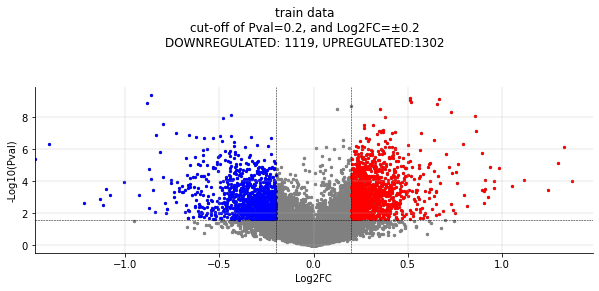


............................................................
 train - Step 1-5
............................................................



input    log  \
sample nr                                              160    160   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.4   
mean tpm value recorded                               32.2    1.8   
max tpm value recorded                            314419.1   18.3   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 60.0%  60.0%   
% of genes not expressed in any sample               18.3%  18.3%   
% of genes expressed in at least 50%  of samples     59.4%  59.4%   
% of genes expressed in all samples                  43.8%  43.8%   

                                                 log_filtered  \
sample nr                                                 160   
gene nr                                                 18475   
- VALUES -                                                      
min tpm value recorded                                    0.0   
median tpm value recorded                                 2.9   
mean tpm value recorded                                   3.1   
max tpm value recorded                                   18.3   
- DETECTED IN -                                                 
mean % of genes expressed per sample                    95.9%   
% of genes not expressed in any sample                   0.0%   
% of genes expressed in at least 50%  of samples       100.0%   
% of genes expressed in all samples                     73.7%   

                                                 log_filtered_scaled  \
sample nr                                                        160   
gene nr                                                        18475   
- VALUES -                                                             
min tpm value recorded                                          -9.2   
median tpm value recorded                                       -0.0   
mean tpm value recorded                                          0.1   
max tpm value recorded                                         328.3   
- DETECTED IN -                                                        
mean % of genes expressed per sample                          100.0%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples              100.0%   
% of genes expressed in all samples                           100.0%   

                                                 outliers_removed top_genes  \
sample nr                                                     152       152   
gene nr                                                     18475      2421   
- VALUES -                                                                    
min tpm value recorded                                       -9.2      -5.5   
median tpm value recorded                                    -0.0      -0.0   
mean tpm value recorded                                       0.1       0.1   
max tpm value recorded                                      328.3      66.3   
- DETECTED IN -                                                               
mean % of genes expressed per sample                       100.0%    100.0%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples           100.0%    100.0%   
% of genes expressed in all samples                        100.0%    100.0%   

                                                 after pca  
sample nr                                              152  
gene nr                                                152  
- VALUES -                                                  
min tpm value recorded                               -64.4  
median tpm value recorded              

............................................................
SIMILARITY BEWEEN SAMPLES
BASED ON GENE EXPRESSION IN THE TOP 2421 
differencially expressed genes
............................................................


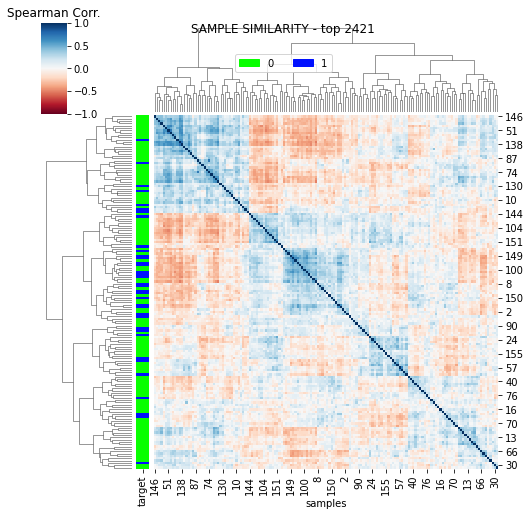

............................................................
GENE EXPRESSION IN THE TOP 
 2421 differencially expressed genes
............................................................


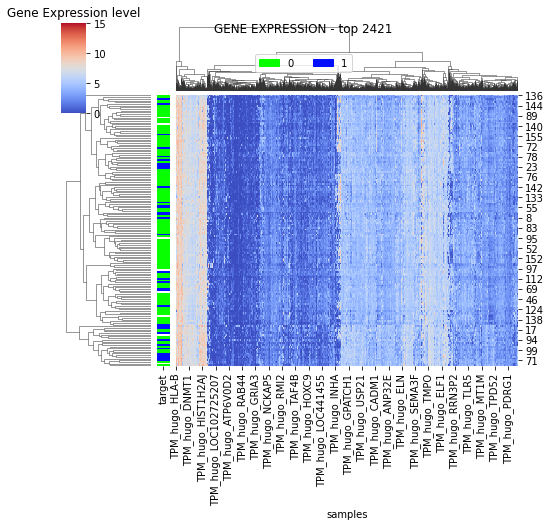

............................................................
PCA and tSNE analysis
............................................................


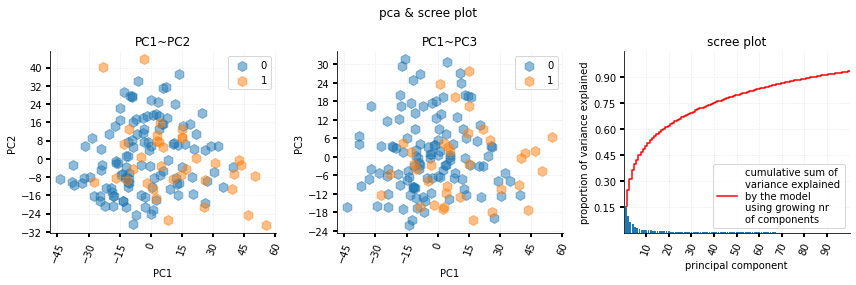


............................................................
 test0 - Step 1-5
............................................................



input    log log_filtered  \
sample nr                                              40     40           40   
gene nr                                             31085  31085        18475   
- VALUES -                                                                      
min tpm value recorded                                0.0    0.0          0.0   
median tpm value recorded                             0.3    0.4          2.9   
mean tpm value recorded                              32.2    1.8          3.1   
max tpm value recorded                            98876.1   16.6         16.6   
- DETECTED IN -                                                                 
mean % of genes expressed per sample                60.4%  60.4%        96.3%   
% of genes not expressed in any sample              22.7%  22.7%         0.0%   
% of genes expressed in at least 50%  of samples    60.1%  60.1%        99.5%   
% of genes expressed in all samples                 47.7%  47.7%        80.3%   

                                                 log_filtered_scaled  \
sample nr                                                         40   
gene nr                                                        18475   
- VALUES -                                                             
min tpm value recorded                                          -6.0   
median tpm value recorded                                       -0.0   
mean tpm value recorded                                          0.1   
max tpm value recorded                                         128.4   
- DETECTED IN -                                                        
mean % of genes expressed per sample                          100.0%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples              100.0%   
% of genes expressed in all samples                           100.0%   

                                                 outliers_removed top_genes  \
sample nr                                                      40        40   
gene nr                                                     18475      2421   
- VALUES -                                                                    
min tpm value recorded                                       -6.0      -6.0   
median tpm value recorded                                    -0.0       0.0   
mean tpm value recorded                                       0.1       0.1   
max tpm value recorded                                      128.4      84.3   
- DETECTED IN -                                                               
mean % of genes expressed per sample                       100.0%    100.0%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples           100.0%    100.0%   
% of genes expressed in all samples                        100.0%    100.0%   

                                                 after pca  
sample nr                                               40  
gene nr                                                152  
- VALUES -                                                  
min tpm value recorded                               -47.6  
median tpm value recorded                              0.0  
mean tpm value recorded                                0.0  
max tpm value recorded                                66.0  
- DETECTED IN -                                             
mean % of genes expressed per sample                100.0%  
% of genes not expressed in any sample                0.0%  
% of genes expressed in at least 50%  of samples    100.0%  
% of genes expressed in all samples                 100.0%


............................................................
 test1 - Step 1-5
............................................................



input    log  \
sample nr                                               98     98   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.4   
mean tpm value recorded                               32.2    1.8   
max tpm value recorded                            133685.0   17.0   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 60.4%  60.4%   
% of genes not expressed in any sample               19.6%  19.6%   
% of genes expressed in at least 50%  of samples     60.0%  60.0%   
% of genes expressed in all samples                  45.6%  45.6%   

                                                 log_filtered  \
sample nr                                                  98   
gene nr                                                 18475   
- VALUES -                                                      
min tpm value recorded                                    0.0   
median tpm value recorded                                 2.9   
mean tpm value recorded                                   3.1   
max tpm value recorded                                   17.0   
- DETECTED IN -                                                 
mean % of genes expressed per sample                    96.2%   
% of genes not expressed in any sample                   0.0%   
% of genes expressed in at least 50%  of samples        99.6%   
% of genes expressed in all samples                     76.7%   

                                                 log_filtered_scaled  \
sample nr                                                         98   
gene nr                                                        18475   
- VALUES -                                                             
min tpm value recorded                                          -6.8   
median tpm value recorded                                        0.0   
mean tpm value recorded                                          0.1   
max tpm value recorded                                         149.5   
- DETECTED IN -                                                        
mean % of genes expressed per sample                          100.0%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples              100.0%   
% of genes expressed in all samples                           100.0%   

                                                 outliers_removed top_genes  \
sample nr                                                      98        98   
gene nr                                                     18475      2421   
- VALUES -                                                                    
min tpm value recorded                                       -6.8      -5.6   
median tpm value recorded                                     0.0       0.0   
mean tpm value recorded                                       0.1       0.1   
max tpm value recorded                                      149.5      34.8   
- DETECTED IN -                                                               
mean % of genes expressed per sample                       100.0%    100.0%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples           100.0%    100.0%   
% of genes expressed in all samples                        100.0%    100.0%   

                                                 after pca  
sample nr                                               98  
gene nr                                                152  
- VALUES -                                                  
min tpm value recorded                               -32.4  
median tpm value recorded              



----------------------------------------

train data ...
df1 shape:  (152, 152)
df2 shape:  (152, 50)
final df:  (152, 202)

validation data ...
df1 shape:  (40, 152)
df2 shape:  (40, 50)
final df:  (40, 202)

test data ...
df1 shape:  (98, 152)
df2 shape:  (98, 50)
final df:  (98, 202)
----------------------------------------


PWD:  /Users/pawel/Desktop/activities/100__Projects/Ardigen/Ardigen/data/interim
SAVED:  DE_genes_PCA_v1__transf_data_dct.p
SAVED:  DE_genes_PCA_v1__qc_reports_dct.p


In [19]:
# create test/validation dataset

n = 40
path = PATH_data_interim
random_nr = 1

# . set seed
np.random.seed(random_nr)

# . create idx, for test/valid datasets
idx_list = list(range(target.shape[0]))
np.random.shuffle(idx_list)
valid_idx = idx_list[0:n]; print(len(valid_idx))
train_idx = idx_list[n:200]; print(len(train_idx))

# . hand made methods - I had some issues with indexes
data_genes_train = data_genes.iloc[train_idx,:]
data_genes_train.reset_index(inplace=True, drop=True)
target_train = target.iloc[train_idx]
target_train.reset_index(inplace=True, drop=True)
data_cov_train = data_cov.iloc[train_idx,:]
data_cov_train.reset_index(inplace=True, drop=True)

# . validation 
data_genes_valid = data_genes.iloc[valid_idx,:]
data_genes_valid.reset_index(inplace=True, drop=True)
target_valid = target.iloc[valid_idx]
target_valid.reset_index(inplace=True, drop=True)
data_cov_valid = data_cov.iloc[valid_idx,:]
data_cov_valid.reset_index(inplace=True, drop=True)

# . run preprocessing pipeline
for data_set_name in list(parameters.keys()):

    transf_data, qc_reports = data_preprocessing_pipeline(
        # ..
        x_train=data_genes_train,
        y_train=target_train,
        cov=data_cov_train,
        cov_data_preprocessor=preprocessor,
        # ..
        x_test_list = [data_genes_valid, data_genes_test],
        y_test_list = [target_valid, None],
        cov_list = [data_cov_valid, data_cov_test],
        # ...
        verbose=1, 
        make_hist=True, 
        **parameters[data_set_name]
        ) 
    
    
    # check file dimensions by using my other function for merging files,

    
    print(f"\n\n{''.join(['-']*40)}")
    dataset_dct = transf_data
 
    print("\ntrain data ...")
    x_train = merge_data(dataset_dct["tpm_data"]["train"], dataset_dct["covariants_data"]["train"])
    y_train = dataset_dct['target_data']["train"]

    print("\nvalidation data ...")
    x_valid = merge_data(dataset_dct["tpm_data"]["test0"], dataset_dct["covariants_data"]["test0"])
    y_valid = dataset_dct['target_data']["test0"]

    print("\ntest data ...")
    x_test = merge_data(dataset_dct["tpm_data"]["test1"], dataset_dct["covariants_data"]["test1"])
    print(f"{''.join(['-']*40)}\n\n")

    
    # save the results
    
    
    os.chdir(path)
    print("PWD: ", path)
    
    # . file name
    prefix = f'{data_set_name}_v{random_nr}'
    
    # . save pickle - its fast, but dont use if you dont trust 
    fname = f"{prefix}__transf_data_dct.p"
    with open(fname, 'wb') as file: # wb - write binary,
                pickle.dump(transf_data, file) 
    print("SAVED: ", fname)

    # . save pickle - its fast, but dont use if you dont trust 
    fname = f"{prefix}__qc_reports_dct.p"
    with open(fname, 'wb') as file: # wb - write binary,
                pickle.dump(qc_reports, file) 
    print("SAVED: ", fname)
    

__Create custom function for detecting differencially expressed genes, between the two classe with tstudent test and foldchnage__
* I applied this, method, as the siples possible option, 
* it can be replaced at any moent with another method, 
* more informaiton on the topic can be found here:
    * "Detecting differentially expressed genes in heterogeneous diseases using half Student’s t-test" https://academic.oup.com/ije/article/39/6/1597/736515
    * "Robustness of differential gene expression analysis of RNA-seq" https://doi.org/10.1016/j.csbj.2021.05.040

## random number 0
---

40
160


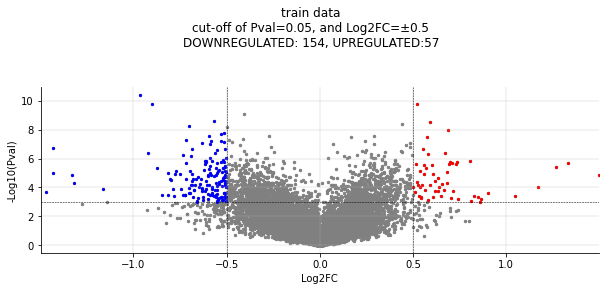


............................................................
 train - Step 1-5
............................................................



input    log  \
sample nr                                              160    160   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.4   
mean tpm value recorded                               32.2    1.8   
max tpm value recorded                            314419.1   18.3   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 60.1%  60.1%   
% of genes not expressed in any sample               18.2%  18.2%   
% of genes expressed in at least 50%  of samples     59.6%  59.6%   
% of genes expressed in all samples                  44.0%  44.0%   

                                                 log_filtered  \
sample nr                                                 160   
gene nr                                                 18534   
- VALUES -                                                      
min tpm value recorded                                    0.0   
median tpm value recorded                                 2.9   
mean tpm value recorded                                   3.1   
max tpm value recorded                                   18.3   
- DETECTED IN -                                                 
mean % of genes expressed per sample                    95.9%   
% of genes not expressed in any sample                   0.0%   
% of genes expressed in at least 50%  of samples       100.0%   
% of genes expressed in all samples                     73.7%   

                                                 log_filtered_scaled  \
sample nr                                                        160   
gene nr                                                        18534   
- VALUES -                                                             
min tpm value recorded                                          -8.7   
median tpm value recorded                                       -0.0   
mean tpm value recorded                                          0.1   
max tpm value recorded                                         336.7   
- DETECTED IN -                                                        
mean % of genes expressed per sample                          100.0%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples              100.0%   
% of genes expressed in all samples                           100.0%   

                                                 outliers_removed top_genes  \
sample nr                                                     152       152   
gene nr                                                     18534       211   
- VALUES -                                                                    
min tpm value recorded                                       -8.7      -4.1   
median tpm value recorded                                     0.0       0.0   
mean tpm value recorded                                       0.1       0.1   
max tpm value recorded                                      336.7      25.2   
- DETECTED IN -                                                               
mean % of genes expressed per sample                       100.0%    100.0%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples           100.0%    100.0%   
% of genes expressed in all samples                        100.0%    100.0%   

                                                 after pca  
sample nr                                              152  
gene nr                                                211  
- VALUES -                                                  
min tpm value recorded                                -4.1  
median tpm value recorded              

............................................................
SIMILARITY BEWEEN SAMPLES
BASED ON GENE EXPRESSION IN THE TOP 211 
differencially expressed genes
............................................................


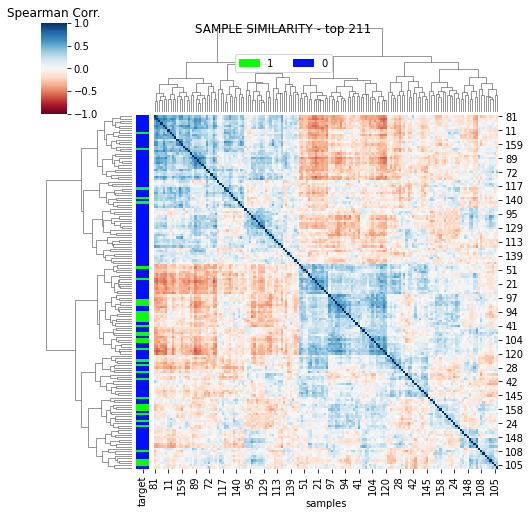

............................................................
GENE EXPRESSION IN THE TOP 
 211 differencially expressed genes
............................................................


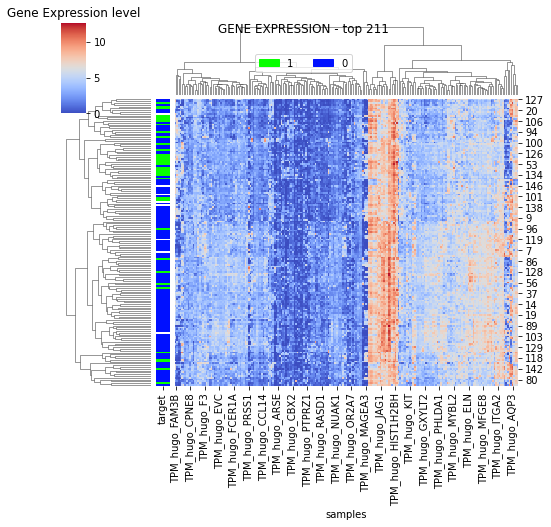

............................................................
PCA and tSNE analysis
............................................................


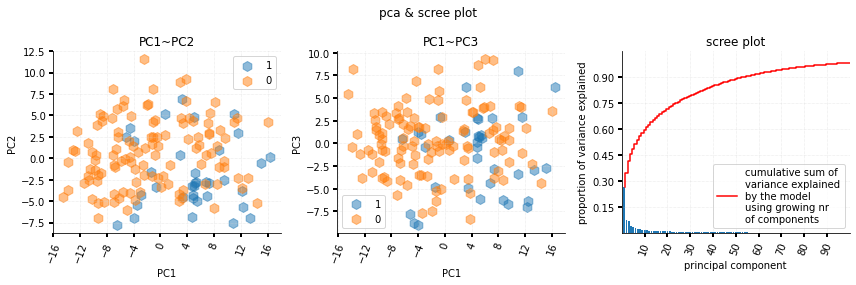


............................................................
 test0 - Step 1-5
............................................................



input    log log_filtered  \
sample nr                                              40     40           40   
gene nr                                             31085  31085        18534   
- VALUES -                                                                      
min tpm value recorded                                0.0    0.0          0.0   
median tpm value recorded                             0.3    0.4          2.9   
mean tpm value recorded                              32.2    1.8          3.1   
max tpm value recorded                            98876.1   16.6         16.6   
- DETECTED IN -                                                                 
mean % of genes expressed per sample                59.9%  59.9%        95.7%   
% of genes not expressed in any sample              22.8%  22.8%         0.0%   
% of genes expressed in at least 50%  of samples    59.5%  59.5%        99.0%   
% of genes expressed in all samples                 46.7%  46.7%        78.4%   

                                                 log_filtered_scaled  \
sample nr                                                         40   
gene nr                                                        18534   
- VALUES -                                                             
min tpm value recorded                                          -6.9   
median tpm value recorded                                       -0.0   
mean tpm value recorded                                          0.1   
max tpm value recorded                                         155.9   
- DETECTED IN -                                                        
mean % of genes expressed per sample                          100.0%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples              100.0%   
% of genes expressed in all samples                           100.0%   

                                                 outliers_removed top_genes  \
sample nr                                                      40        40   
gene nr                                                     18534       211   
- VALUES -                                                                    
min tpm value recorded                                       -6.9      -3.3   
median tpm value recorded                                    -0.0      -0.0   
mean tpm value recorded                                       0.1       0.0   
max tpm value recorded                                      155.9      10.2   
- DETECTED IN -                                                               
mean % of genes expressed per sample                       100.0%    100.0%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples           100.0%    100.0%   
% of genes expressed in all samples                        100.0%    100.0%   

                                                 after pca  
sample nr                                               40  
gene nr                                                211  
- VALUES -                                                  
min tpm value recorded                                -3.3  
median tpm value recorded                             -0.0  
mean tpm value recorded                                0.0  
max tpm value recorded                                10.2  
- DETECTED IN -                                             
mean % of genes expressed per sample                100.0%  
% of genes not expressed in any sample                0.0%  
% of genes expressed in at least 50%  of samples    100.0%  
% of genes expressed in all samples                 100.0%


............................................................
 test1 - Step 1-5
............................................................



input    log  \
sample nr                                               98     98   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.4   
mean tpm value recorded                               32.2    1.8   
max tpm value recorded                            133685.0   17.0   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 60.4%  60.4%   
% of genes not expressed in any sample               19.6%  19.6%   
% of genes expressed in at least 50%  of samples     60.0%  60.0%   
% of genes expressed in all samples                  45.6%  45.6%   

                                                 log_filtered  \
sample nr                                                  98   
gene nr                                                 18534   
- VALUES -                                                      
min tpm value recorded                                    0.0   
median tpm value recorded                                 2.9   
mean tpm value recorded                                   3.1   
max tpm value recorded                                   17.0   
- DETECTED IN -                                                 
mean % of genes expressed per sample                    96.1%   
% of genes not expressed in any sample                   0.0%   
% of genes expressed in at least 50%  of samples        99.5%   
% of genes expressed in all samples                     76.5%   

                                                 log_filtered_scaled  \
sample nr                                                         98   
gene nr                                                        18534   
- VALUES -                                                             
min tpm value recorded                                          -6.9   
median tpm value recorded                                        0.0   
mean tpm value recorded                                          0.1   
max tpm value recorded                                         171.3   
- DETECTED IN -                                                        
mean % of genes expressed per sample                          100.0%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples              100.0%   
% of genes expressed in all samples                           100.0%   

                                                 outliers_removed top_genes  \
sample nr                                                      98        98   
gene nr                                                     18534       211   
- VALUES -                                                                    
min tpm value recorded                                       -6.9      -3.4   
median tpm value recorded                                     0.0      -0.0   
mean tpm value recorded                                       0.1       0.1   
max tpm value recorded                                      171.3      14.0   
- DETECTED IN -                                                               
mean % of genes expressed per sample                       100.0%    100.0%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples           100.0%    100.0%   
% of genes expressed in all samples                        100.0%    100.0%   

                                                 after pca  
sample nr                                               98  
gene nr                                                211  
- VALUES -                                                  
min tpm value recorded                                -3.4  
median tpm value recorded              



----------------------------------------

train data ...
df1 shape:  (152, 211)
df2 shape:  (152, 50)
final df:  (152, 261)

validation data ...
df1 shape:  (40, 211)
df2 shape:  (40, 50)
final df:  (40, 261)

test data ...
df1 shape:  (98, 211)
df2 shape:  (98, 50)
final df:  (98, 261)
----------------------------------------


PWD:  /Users/pawel/Desktop/activities/100__Projects/Ardigen/Ardigen/data/interim
SAVED:  Signif_genes_v0__transf_data_dct.p
SAVED:  Signif_genes_v0__qc_reports_dct.p


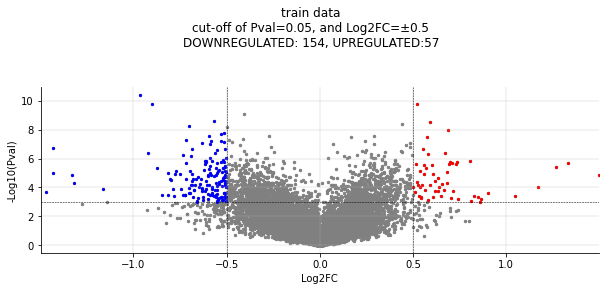


............................................................
 train - Step 1-5
............................................................



input    log  \
sample nr                                              160    160   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.4   
mean tpm value recorded                               32.2    1.8   
max tpm value recorded                            314419.1   18.3   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 60.1%  60.1%   
% of genes not expressed in any sample               18.2%  18.2%   
% of genes expressed in at least 50%  of samples     59.6%  59.6%   
% of genes expressed in all samples                  44.0%  44.0%   

                                                 log_filtered  \
sample nr                                                 160   
gene nr                                                 18534   
- VALUES -                                                      
min tpm value recorded                                    0.0   
median tpm value recorded                                 2.9   
mean tpm value recorded                                   3.1   
max tpm value recorded                                   18.3   
- DETECTED IN -                                                 
mean % of genes expressed per sample                    95.9%   
% of genes not expressed in any sample                   0.0%   
% of genes expressed in at least 50%  of samples       100.0%   
% of genes expressed in all samples                     73.7%   

                                                 log_filtered_scaled  \
sample nr                                                        160   
gene nr                                                        18534   
- VALUES -                                                             
min tpm value recorded                                          -8.7   
median tpm value recorded                                       -0.0   
mean tpm value recorded                                          0.1   
max tpm value recorded                                         336.7   
- DETECTED IN -                                                        
mean % of genes expressed per sample                          100.0%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples              100.0%   
% of genes expressed in all samples                           100.0%   

                                                 outliers_removed top_genes  \
sample nr                                                     152       152   
gene nr                                                     18534       211   
- VALUES -                                                                    
min tpm value recorded                                       -8.7      -4.1   
median tpm value recorded                                     0.0       0.0   
mean tpm value recorded                                       0.1       0.1   
max tpm value recorded                                      336.7      25.2   
- DETECTED IN -                                                               
mean % of genes expressed per sample                       100.0%    100.0%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples           100.0%    100.0%   
% of genes expressed in all samples                        100.0%    100.0%   

                                                 after pca  
sample nr                                              152  
gene nr                                                152  
- VALUES -                                                  
min tpm value recorded                               -10.7  
median tpm value recorded              

............................................................
SIMILARITY BEWEEN SAMPLES
BASED ON GENE EXPRESSION IN THE TOP 211 
differencially expressed genes
............................................................


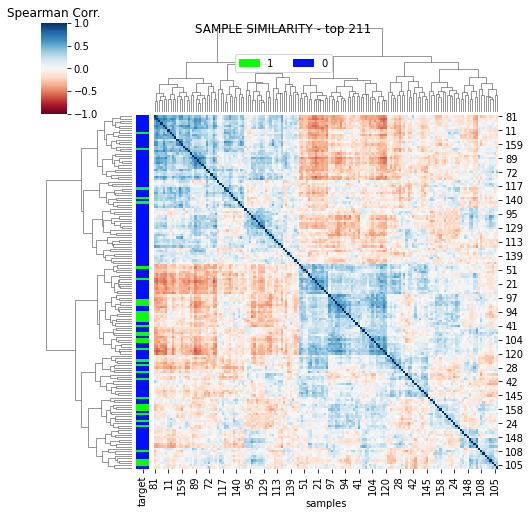

............................................................
GENE EXPRESSION IN THE TOP 
 211 differencially expressed genes
............................................................


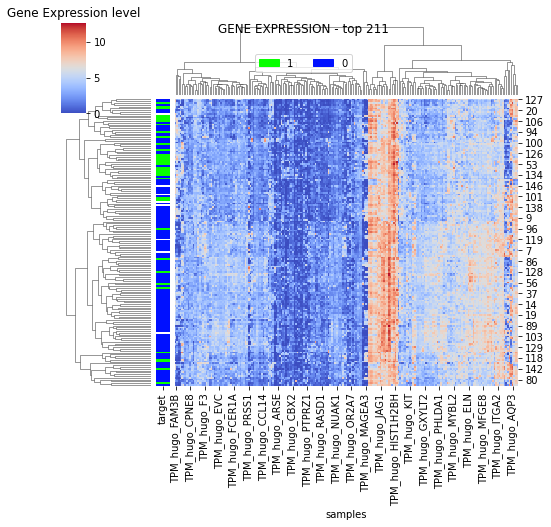

............................................................
PCA and tSNE analysis
............................................................


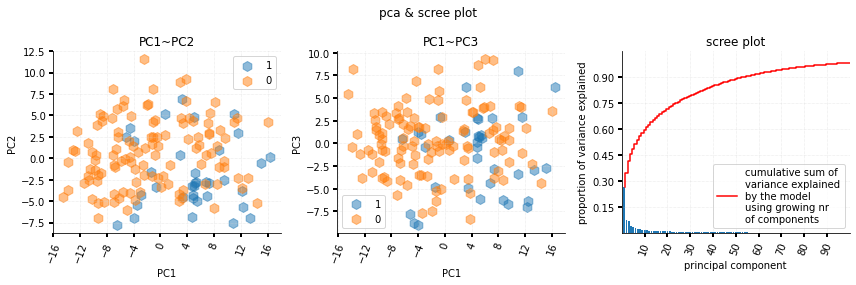


............................................................
 test0 - Step 1-5
............................................................



input    log log_filtered  \
sample nr                                              40     40           40   
gene nr                                             31085  31085        18534   
- VALUES -                                                                      
min tpm value recorded                                0.0    0.0          0.0   
median tpm value recorded                             0.3    0.4          2.9   
mean tpm value recorded                              32.2    1.8          3.1   
max tpm value recorded                            98876.1   16.6         16.6   
- DETECTED IN -                                                                 
mean % of genes expressed per sample                59.9%  59.9%        95.7%   
% of genes not expressed in any sample              22.8%  22.8%         0.0%   
% of genes expressed in at least 50%  of samples    59.5%  59.5%        99.0%   
% of genes expressed in all samples                 46.7%  46.7%        78.4%   

                                                 log_filtered_scaled  \
sample nr                                                         40   
gene nr                                                        18534   
- VALUES -                                                             
min tpm value recorded                                          -6.9   
median tpm value recorded                                       -0.0   
mean tpm value recorded                                          0.1   
max tpm value recorded                                         155.9   
- DETECTED IN -                                                        
mean % of genes expressed per sample                          100.0%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples              100.0%   
% of genes expressed in all samples                           100.0%   

                                                 outliers_removed top_genes  \
sample nr                                                      40        40   
gene nr                                                     18534       211   
- VALUES -                                                                    
min tpm value recorded                                       -6.9      -3.3   
median tpm value recorded                                    -0.0      -0.0   
mean tpm value recorded                                       0.1       0.0   
max tpm value recorded                                      155.9      10.2   
- DETECTED IN -                                                               
mean % of genes expressed per sample                       100.0%    100.0%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples           100.0%    100.0%   
% of genes expressed in all samples                        100.0%    100.0%   

                                                 after pca  
sample nr                                               40  
gene nr                                                152  
- VALUES -                                                  
min tpm value recorded                               -10.1  
median tpm value recorded                              0.0  
mean tpm value recorded                                0.0  
max tpm value recorded                                10.2  
- DETECTED IN -                                             
mean % of genes expressed per sample                100.0%  
% of genes not expressed in any sample                0.0%  
% of genes expressed in at least 50%  of samples    100.0%  
% of genes expressed in all samples                 100.0%


............................................................
 test1 - Step 1-5
............................................................



input    log  \
sample nr                                               98     98   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.4   
mean tpm value recorded                               32.2    1.8   
max tpm value recorded                            133685.0   17.0   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 60.4%  60.4%   
% of genes not expressed in any sample               19.6%  19.6%   
% of genes expressed in at least 50%  of samples     60.0%  60.0%   
% of genes expressed in all samples                  45.6%  45.6%   

                                                 log_filtered  \
sample nr                                                  98   
gene nr                                                 18534   
- VALUES -                                                      
min tpm value recorded                                    0.0   
median tpm value recorded                                 2.9   
mean tpm value recorded                                   3.1   
max tpm value recorded                                   17.0   
- DETECTED IN -                                                 
mean % of genes expressed per sample                    96.1%   
% of genes not expressed in any sample                   0.0%   
% of genes expressed in at least 50%  of samples        99.5%   
% of genes expressed in all samples                     76.5%   

                                                 log_filtered_scaled  \
sample nr                                                         98   
gene nr                                                        18534   
- VALUES -                                                             
min tpm value recorded                                          -6.9   
median tpm value recorded                                        0.0   
mean tpm value recorded                                          0.1   
max tpm value recorded                                         171.3   
- DETECTED IN -                                                        
mean % of genes expressed per sample                          100.0%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples              100.0%   
% of genes expressed in all samples                           100.0%   

                                                 outliers_removed top_genes  \
sample nr                                                      98        98   
gene nr                                                     18534       211   
- VALUES -                                                                    
min tpm value recorded                                       -6.9      -3.4   
median tpm value recorded                                     0.0      -0.0   
mean tpm value recorded                                       0.1       0.1   
max tpm value recorded                                      171.3      14.0   
- DETECTED IN -                                                               
mean % of genes expressed per sample                       100.0%    100.0%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples           100.0%    100.0%   
% of genes expressed in all samples                        100.0%    100.0%   

                                                 after pca  
sample nr                                               98  
gene nr                                                152  
- VALUES -                                                  
min tpm value recorded                               -12.4  
median tpm value recorded              



----------------------------------------

train data ...
df1 shape:  (152, 152)
df2 shape:  (152, 50)
final df:  (152, 202)

validation data ...
df1 shape:  (40, 152)
df2 shape:  (40, 50)
final df:  (40, 202)

test data ...
df1 shape:  (98, 152)
df2 shape:  (98, 50)
final df:  (98, 202)
----------------------------------------


PWD:  /Users/pawel/Desktop/activities/100__Projects/Ardigen/Ardigen/data/interim
SAVED:  Signif_genes_PCA_v0__transf_data_dct.p
SAVED:  Signif_genes_PCA_v0__qc_reports_dct.p


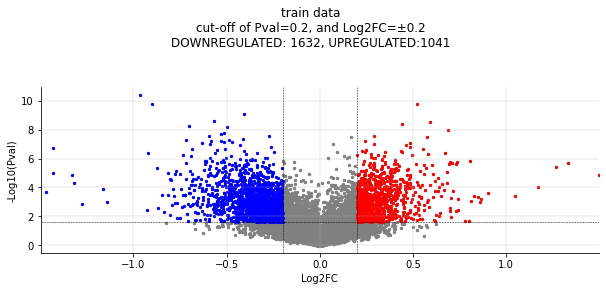


............................................................
 train - Step 1-5
............................................................



input    log  \
sample nr                                              160    160   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.4   
mean tpm value recorded                               32.2    1.8   
max tpm value recorded                            314419.1   18.3   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 60.1%  60.1%   
% of genes not expressed in any sample               18.2%  18.2%   
% of genes expressed in at least 50%  of samples     59.6%  59.6%   
% of genes expressed in all samples                  44.0%  44.0%   

                                                 log_filtered  \
sample nr                                                 160   
gene nr                                                 18534   
- VALUES -                                                      
min tpm value recorded                                    0.0   
median tpm value recorded                                 2.9   
mean tpm value recorded                                   3.1   
max tpm value recorded                                   18.3   
- DETECTED IN -                                                 
mean % of genes expressed per sample                    95.9%   
% of genes not expressed in any sample                   0.0%   
% of genes expressed in at least 50%  of samples       100.0%   
% of genes expressed in all samples                     73.7%   

                                                 log_filtered_scaled  \
sample nr                                                        160   
gene nr                                                        18534   
- VALUES -                                                             
min tpm value recorded                                          -8.7   
median tpm value recorded                                       -0.0   
mean tpm value recorded                                          0.1   
max tpm value recorded                                         336.7   
- DETECTED IN -                                                        
mean % of genes expressed per sample                          100.0%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples              100.0%   
% of genes expressed in all samples                           100.0%   

                                                 outliers_removed top_genes  \
sample nr                                                     152       152   
gene nr                                                     18534      2673   
- VALUES -                                                                    
min tpm value recorded                                       -8.7      -5.2   
median tpm value recorded                                     0.0       0.0   
mean tpm value recorded                                       0.1       0.1   
max tpm value recorded                                      336.7     171.1   
- DETECTED IN -                                                               
mean % of genes expressed per sample                       100.0%    100.0%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples           100.0%    100.0%   
% of genes expressed in all samples                        100.0%    100.0%   

                                                 after pca  
sample nr                                              152  
gene nr                                                152  
- VALUES -                                                  
min tpm value recorded                               -44.3  
median tpm value recorded              

............................................................
SIMILARITY BEWEEN SAMPLES
BASED ON GENE EXPRESSION IN THE TOP 2673 
differencially expressed genes
............................................................


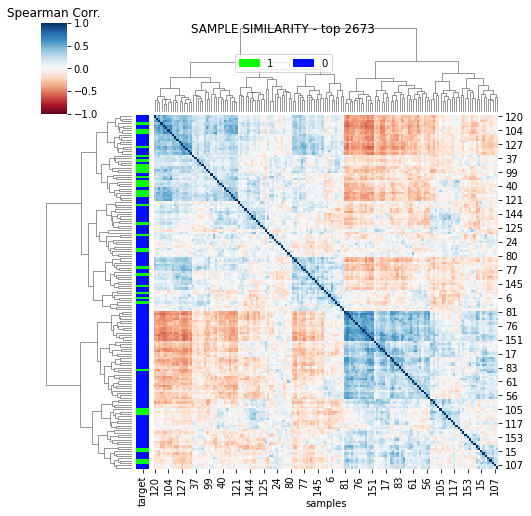

............................................................
GENE EXPRESSION IN THE TOP 
 2673 differencially expressed genes
............................................................


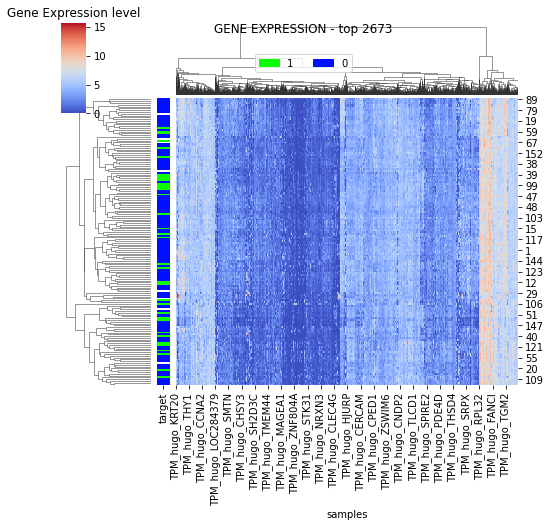

............................................................
PCA and tSNE analysis
............................................................


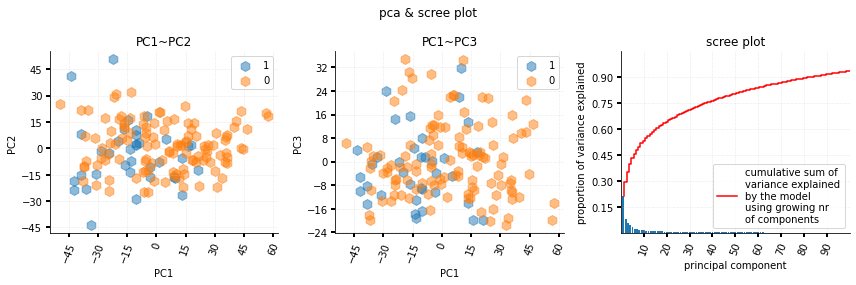


............................................................
 test0 - Step 1-5
............................................................



input    log log_filtered  \
sample nr                                              40     40           40   
gene nr                                             31085  31085        18534   
- VALUES -                                                                      
min tpm value recorded                                0.0    0.0          0.0   
median tpm value recorded                             0.3    0.4          2.9   
mean tpm value recorded                              32.2    1.8          3.1   
max tpm value recorded                            98876.1   16.6         16.6   
- DETECTED IN -                                                                 
mean % of genes expressed per sample                59.9%  59.9%        95.7%   
% of genes not expressed in any sample              22.8%  22.8%         0.0%   
% of genes expressed in at least 50%  of samples    59.5%  59.5%        99.0%   
% of genes expressed in all samples                 46.7%  46.7%        78.4%   

                                                 log_filtered_scaled  \
sample nr                                                         40   
gene nr                                                        18534   
- VALUES -                                                             
min tpm value recorded                                          -6.9   
median tpm value recorded                                       -0.0   
mean tpm value recorded                                          0.1   
max tpm value recorded                                         155.9   
- DETECTED IN -                                                        
mean % of genes expressed per sample                          100.0%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples              100.0%   
% of genes expressed in all samples                           100.0%   

                                                 outliers_removed top_genes  \
sample nr                                                      40        40   
gene nr                                                     18534      2673   
- VALUES -                                                                    
min tpm value recorded                                       -6.9      -4.5   
median tpm value recorded                                    -0.0      -0.0   
mean tpm value recorded                                       0.1       0.0   
max tpm value recorded                                      155.9      46.5   
- DETECTED IN -                                                               
mean % of genes expressed per sample                       100.0%    100.0%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples           100.0%    100.0%   
% of genes expressed in all samples                        100.0%    100.0%   

                                                 after pca  
sample nr                                               40  
gene nr                                                152  
- VALUES -                                                  
min tpm value recorded                               -35.8  
median tpm value recorded                              0.0  
mean tpm value recorded                                0.0  
max tpm value recorded                                43.9  
- DETECTED IN -                                             
mean % of genes expressed per sample                100.0%  
% of genes not expressed in any sample                0.0%  
% of genes expressed in at least 50%  of samples    100.0%  
% of genes expressed in all samples                 100.0%


............................................................
 test1 - Step 1-5
............................................................



input    log  \
sample nr                                               98     98   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.4   
mean tpm value recorded                               32.2    1.8   
max tpm value recorded                            133685.0   17.0   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 60.4%  60.4%   
% of genes not expressed in any sample               19.6%  19.6%   
% of genes expressed in at least 50%  of samples     60.0%  60.0%   
% of genes expressed in all samples                  45.6%  45.6%   

                                                 log_filtered  \
sample nr                                                  98   
gene nr                                                 18534   
- VALUES -                                                      
min tpm value recorded                                    0.0   
median tpm value recorded                                 2.9   
mean tpm value recorded                                   3.1   
max tpm value recorded                                   17.0   
- DETECTED IN -                                                 
mean % of genes expressed per sample                    96.1%   
% of genes not expressed in any sample                   0.0%   
% of genes expressed in at least 50%  of samples        99.5%   
% of genes expressed in all samples                     76.5%   

                                                 log_filtered_scaled  \
sample nr                                                         98   
gene nr                                                        18534   
- VALUES -                                                             
min tpm value recorded                                          -6.9   
median tpm value recorded                                        0.0   
mean tpm value recorded                                          0.1   
max tpm value recorded                                         171.3   
- DETECTED IN -                                                        
mean % of genes expressed per sample                          100.0%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples              100.0%   
% of genes expressed in all samples                           100.0%   

                                                 outliers_removed top_genes  \
sample nr                                                      98        98   
gene nr                                                     18534      2673   
- VALUES -                                                                    
min tpm value recorded                                       -6.9      -5.4   
median tpm value recorded                                     0.0       0.0   
mean tpm value recorded                                       0.1       0.1   
max tpm value recorded                                      171.3      76.3   
- DETECTED IN -                                                               
mean % of genes expressed per sample                       100.0%    100.0%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples           100.0%    100.0%   
% of genes expressed in all samples                        100.0%    100.0%   

                                                 after pca  
sample nr                                               98  
gene nr                                                152  
- VALUES -                                                  
min tpm value recorded                               -41.4  
median tpm value recorded              



----------------------------------------

train data ...
df1 shape:  (152, 152)
df2 shape:  (152, 50)
final df:  (152, 202)

validation data ...
df1 shape:  (40, 152)
df2 shape:  (40, 50)
final df:  (40, 202)

test data ...
df1 shape:  (98, 152)
df2 shape:  (98, 50)
final df:  (98, 202)
----------------------------------------


PWD:  /Users/pawel/Desktop/activities/100__Projects/Ardigen/Ardigen/data/interim
SAVED:  DE_genes_PCA_v0__transf_data_dct.p
SAVED:  DE_genes_PCA_v0__qc_reports_dct.p


In [20]:
# create test/validation dataset

n = 40
path = PATH_data_interim
random_nr = 0

# . set seed
np.random.seed(random_nr)

# . create idx, for test/valid datasets
idx_list = list(range(target.shape[0]))
np.random.shuffle(idx_list)
valid_idx = idx_list[0:n]; print(len(valid_idx))
train_idx = idx_list[n:200]; print(len(train_idx))

# . hand made methods - I had some issues with indexes
data_genes_train = data_genes.iloc[train_idx,:]
data_genes_train.reset_index(inplace=True, drop=True)
target_train = target.iloc[train_idx]
target_train.reset_index(inplace=True, drop=True)
data_cov_train = data_cov.iloc[train_idx,:]
data_cov_train.reset_index(inplace=True, drop=True)

# . validation 
data_genes_valid = data_genes.iloc[valid_idx,:]
data_genes_valid.reset_index(inplace=True, drop=True)
target_valid = target.iloc[valid_idx]
target_valid.reset_index(inplace=True, drop=True)
data_cov_valid = data_cov.iloc[valid_idx,:]
data_cov_valid.reset_index(inplace=True, drop=True)

# . run preprocessing pipeline
for data_set_name in list(parameters.keys()):

    transf_data, qc_reports = data_preprocessing_pipeline(
        # ..
        x_train=data_genes_train,
        y_train=target_train,
        cov=data_cov_train,
        cov_data_preprocessor=preprocessor,
        # ..
        x_test_list = [data_genes_valid, data_genes_test],
        y_test_list = [target_valid, None],
        cov_list = [data_cov_valid, data_cov_test],
        # ...
        verbose=1, 
        make_hist=True, 
        **parameters[data_set_name]
        ) 
    
    
    # check file dimensions by using my other function for merging files,

    
    print(f"\n\n{''.join(['-']*40)}")
    dataset_dct = transf_data
 
    print("\ntrain data ...")
    x_train = merge_data(dataset_dct["tpm_data"]["train"], dataset_dct["covariants_data"]["train"])
    y_train = dataset_dct['target_data']["train"]

    print("\nvalidation data ...")
    x_valid = merge_data(dataset_dct["tpm_data"]["test0"], dataset_dct["covariants_data"]["test0"])
    y_valid = dataset_dct['target_data']["test0"]

    print("\ntest data ...")
    x_test = merge_data(dataset_dct["tpm_data"]["test1"], dataset_dct["covariants_data"]["test1"])
    print(f"{''.join(['-']*40)}\n\n")

    
    # save the results
    
    
    os.chdir(path)
    print("PWD: ", path)
    
    # . file name
    prefix = f'{data_set_name}_v{random_nr}'
    
    # . save pickle - its fast, but dont use if you dont trust 
    fname = f"{prefix}__transf_data_dct.p"
    with open(fname, 'wb') as file: # wb - write binary,
                pickle.dump(transf_data, file) 
    print("SAVED: ", fname)

    # . save pickle - its fast, but dont use if you dont trust 
    fname = f"{prefix}__qc_reports_dct.p"
    with open(fname, 'wb') as file: # wb - write binary,
                pickle.dump(qc_reports, file) 
    print("SAVED: ", fname)
    

In [21]:
%ls

DE_genes_PCA_v0__qc_reports_dct.p       Signif_genes_PCA_v1__qc_reports_dct.p
DE_genes_PCA_v0__transf_data_dct.p      Signif_genes_PCA_v1__transf_data_dct.p
DE_genes_PCA_v1__qc_reports_dct.p       Signif_genes_v0__qc_reports_dct.p
DE_genes_PCA_v1__transf_data_dct.p      Signif_genes_v0__transf_data_dct.p
Signif_genes_PCA_v0__qc_reports_dct.p   Signif_genes_v1__qc_reports_dct.p
Signif_genes_PCA_v0__transf_data_dct.p  Signif_genes_v1__transf_data_dct.p


40
160


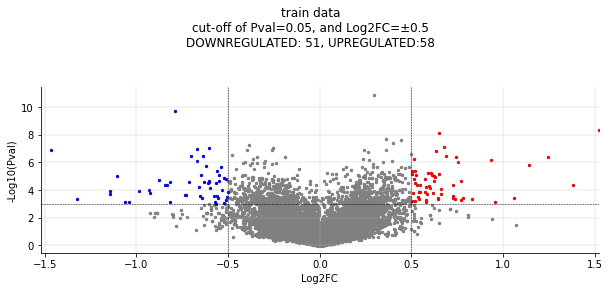


............................................................
 train - Step 1-5
............................................................



input    log  \
sample nr                                              160    160   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.4   
mean tpm value recorded                               32.2    1.8   
max tpm value recorded                            314419.1   18.3   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 60.2%  60.2%   
% of genes not expressed in any sample               18.1%  18.1%   
% of genes expressed in at least 50%  of samples     59.7%  59.7%   
% of genes expressed in all samples                  44.5%  44.5%   

                                                 log_filtered  \
sample nr                                                 160   
gene nr                                                 18555   
- VALUES -                                                      
min tpm value recorded                                    0.0   
median tpm value recorded                                 2.9   
mean tpm value recorded                                   3.1   
max tpm value recorded                                   18.3   
- DETECTED IN -                                                 
mean % of genes expressed per sample                    95.9%   
% of genes not expressed in any sample                   0.0%   
% of genes expressed in at least 50%  of samples       100.0%   
% of genes expressed in all samples                     74.5%   

                                                 log_filtered_scaled  \
sample nr                                                        160   
gene nr                                                        18555   
- VALUES -                                                             
min tpm value recorded                                          -9.4   
median tpm value recorded                                        0.0   
mean tpm value recorded                                          0.1   
max tpm value recorded                                         301.8   
- DETECTED IN -                                                        
mean % of genes expressed per sample                          100.0%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples              100.0%   
% of genes expressed in all samples                           100.0%   

                                                 outliers_removed top_genes  \
sample nr                                                     152       152   
gene nr                                                     18555       109   
- VALUES -                                                                    
min tpm value recorded                                       -9.4      -3.3   
median tpm value recorded                                     0.0      -0.0   
mean tpm value recorded                                       0.1       0.1   
max tpm value recorded                                      226.7      21.0   
- DETECTED IN -                                                               
mean % of genes expressed per sample                       100.0%    100.0%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples           100.0%    100.0%   
% of genes expressed in all samples                        100.0%    100.0%   

                                                 after pca  
sample nr                                              152  
gene nr                                                109  
- VALUES -                                                  
min tpm value recorded                                -3.3  
median tpm value recorded              

............................................................
SIMILARITY BEWEEN SAMPLES
BASED ON GENE EXPRESSION IN THE TOP 109 
differencially expressed genes
............................................................


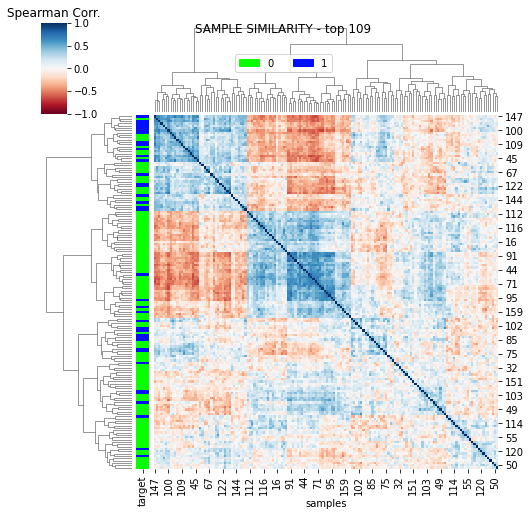

............................................................
GENE EXPRESSION IN THE TOP 
 109 differencially expressed genes
............................................................


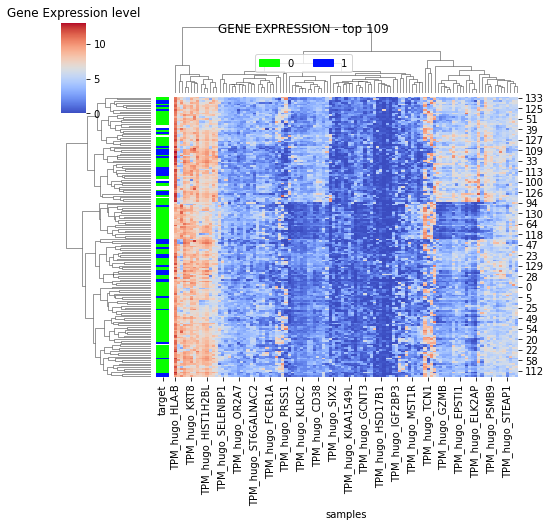

............................................................
PCA and tSNE analysis
............................................................


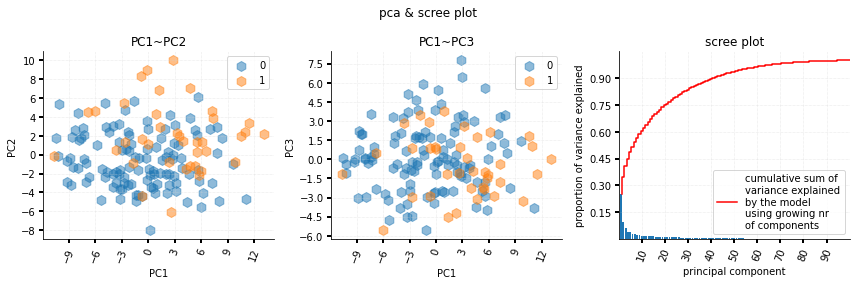


............................................................
 test0 - Step 1-5
............................................................



input    log log_filtered  \
sample nr                                              40     40           40   
gene nr                                             31085  31085        18555   
- VALUES -                                                                      
min tpm value recorded                                0.0    0.0          0.0   
median tpm value recorded                             0.3    0.4          2.9   
mean tpm value recorded                              32.2    1.8          3.1   
max tpm value recorded                            89880.5   16.5         16.5   
- DETECTED IN -                                                                 
mean % of genes expressed per sample                59.6%  59.6%        95.2%   
% of genes not expressed in any sample              23.1%  23.1%         0.0%   
% of genes expressed in at least 50%  of samples    59.2%  59.2%        98.6%   
% of genes expressed in all samples                 45.8%  45.8%        76.7%   

                                                 log_filtered_scaled  \
sample nr                                                         40   
gene nr                                                        18555   
- VALUES -                                                             
min tpm value recorded                                          -5.9   
median tpm value recorded                                       -0.0   
mean tpm value recorded                                          0.1   
max tpm value recorded                                         289.5   
- DETECTED IN -                                                        
mean % of genes expressed per sample                          100.0%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples              100.0%   
% of genes expressed in all samples                           100.0%   

                                                 outliers_removed top_genes  \
sample nr                                                      40        40   
gene nr                                                     18555       109   
- VALUES -                                                                    
min tpm value recorded                                       -5.9      -3.3   
median tpm value recorded                                    -0.0       0.0   
mean tpm value recorded                                       0.1       0.1   
max tpm value recorded                                      289.5       8.5   
- DETECTED IN -                                                               
mean % of genes expressed per sample                       100.0%    100.0%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples           100.0%    100.0%   
% of genes expressed in all samples                        100.0%    100.0%   

                                                 after pca  
sample nr                                               40  
gene nr                                                109  
- VALUES -                                                  
min tpm value recorded                                -3.3  
median tpm value recorded                              0.0  
mean tpm value recorded                                0.1  
max tpm value recorded                                 8.5  
- DETECTED IN -                                             
mean % of genes expressed per sample                100.0%  
% of genes not expressed in any sample                0.0%  
% of genes expressed in at least 50%  of samples    100.0%  
% of genes expressed in all samples                 100.0%


............................................................
 test1 - Step 1-5
............................................................



input    log  \
sample nr                                               98     98   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.4   
mean tpm value recorded                               32.2    1.8   
max tpm value recorded                            133685.0   17.0   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 60.4%  60.4%   
% of genes not expressed in any sample               19.6%  19.6%   
% of genes expressed in at least 50%  of samples     60.0%  60.0%   
% of genes expressed in all samples                  45.6%  45.6%   

                                                 log_filtered  \
sample nr                                                  98   
gene nr                                                 18555   
- VALUES -                                                      
min tpm value recorded                                    0.0   
median tpm value recorded                                 2.9   
mean tpm value recorded                                   3.1   
max tpm value recorded                                   17.0   
- DETECTED IN -                                                 
mean % of genes expressed per sample                    96.0%   
% of genes not expressed in any sample                   0.0%   
% of genes expressed in at least 50%  of samples        99.4%   
% of genes expressed in all samples                     76.4%   

                                                 log_filtered_scaled  \
sample nr                                                         98   
gene nr                                                        18555   
- VALUES -                                                             
min tpm value recorded                                          -7.1   
median tpm value recorded                                        0.0   
mean tpm value recorded                                          0.1   
max tpm value recorded                                         188.2   
- DETECTED IN -                                                        
mean % of genes expressed per sample                          100.0%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples              100.0%   
% of genes expressed in all samples                           100.0%   

                                                 outliers_removed top_genes  \
sample nr                                                      98        98   
gene nr                                                     18555       109   
- VALUES -                                                                    
min tpm value recorded                                       -7.1      -3.1   
median tpm value recorded                                     0.0       0.0   
mean tpm value recorded                                       0.1       0.1   
max tpm value recorded                                      188.2      10.6   
- DETECTED IN -                                                               
mean % of genes expressed per sample                       100.0%    100.0%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples           100.0%    100.0%   
% of genes expressed in all samples                        100.0%    100.0%   

                                                 after pca  
sample nr                                               98  
gene nr                                                109  
- VALUES -                                                  
min tpm value recorded                                -3.1  
median tpm value recorded              



----------------------------------------

train data ...
df1 shape:  (152, 109)
df2 shape:  (152, 50)
final df:  (152, 159)

validation data ...
df1 shape:  (40, 109)
df2 shape:  (40, 50)
final df:  (40, 159)

test data ...
df1 shape:  (98, 109)
df2 shape:  (98, 50)
final df:  (98, 159)
----------------------------------------


PWD:  /Users/pawel/Desktop/activities/100__Projects/Ardigen/Ardigen/data/interim
SAVED:  Signif_genes_v2__transf_data_dct.p
SAVED:  Signif_genes_v2__qc_reports_dct.p


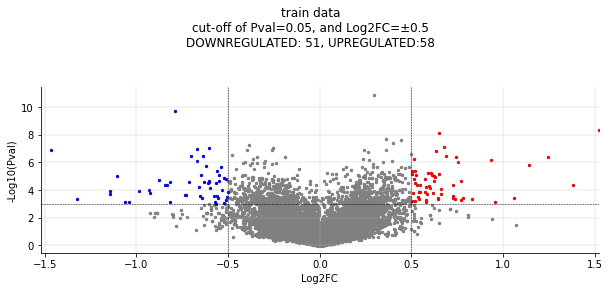


............................................................
 train - Step 1-5
............................................................



input    log  \
sample nr                                              160    160   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.4   
mean tpm value recorded                               32.2    1.8   
max tpm value recorded                            314419.1   18.3   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 60.2%  60.2%   
% of genes not expressed in any sample               18.1%  18.1%   
% of genes expressed in at least 50%  of samples     59.7%  59.7%   
% of genes expressed in all samples                  44.5%  44.5%   

                                                 log_filtered  \
sample nr                                                 160   
gene nr                                                 18555   
- VALUES -                                                      
min tpm value recorded                                    0.0   
median tpm value recorded                                 2.9   
mean tpm value recorded                                   3.1   
max tpm value recorded                                   18.3   
- DETECTED IN -                                                 
mean % of genes expressed per sample                    95.9%   
% of genes not expressed in any sample                   0.0%   
% of genes expressed in at least 50%  of samples       100.0%   
% of genes expressed in all samples                     74.5%   

                                                 log_filtered_scaled  \
sample nr                                                        160   
gene nr                                                        18555   
- VALUES -                                                             
min tpm value recorded                                          -9.4   
median tpm value recorded                                        0.0   
mean tpm value recorded                                          0.1   
max tpm value recorded                                         301.8   
- DETECTED IN -                                                        
mean % of genes expressed per sample                          100.0%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples              100.0%   
% of genes expressed in all samples                           100.0%   

                                                 outliers_removed top_genes  \
sample nr                                                     152       152   
gene nr                                                     18555       109   
- VALUES -                                                                    
min tpm value recorded                                       -9.4      -3.3   
median tpm value recorded                                     0.0      -0.0   
mean tpm value recorded                                       0.1       0.1   
max tpm value recorded                                      226.7      21.0   
- DETECTED IN -                                                               
mean % of genes expressed per sample                       100.0%    100.0%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples           100.0%    100.0%   
% of genes expressed in all samples                        100.0%    100.0%   

                                                 after pca  
sample nr                                              152  
gene nr                                                109  
- VALUES -                                                  
min tpm value recorded                                -8.4  
median tpm value recorded              

............................................................
SIMILARITY BEWEEN SAMPLES
BASED ON GENE EXPRESSION IN THE TOP 109 
differencially expressed genes
............................................................


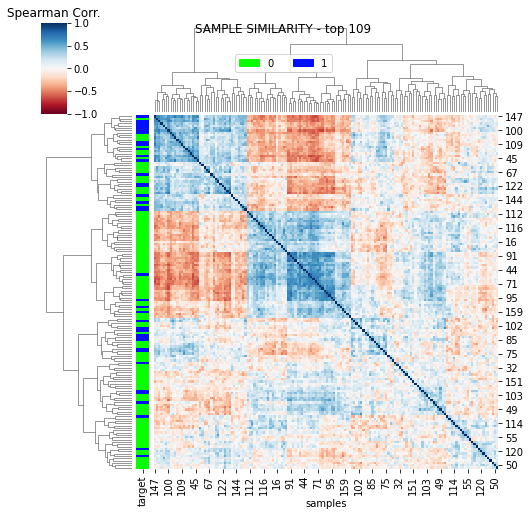

............................................................
GENE EXPRESSION IN THE TOP 
 109 differencially expressed genes
............................................................


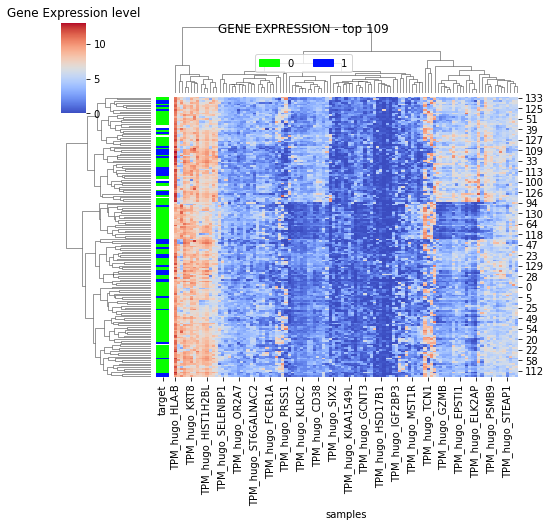

............................................................
PCA and tSNE analysis
............................................................


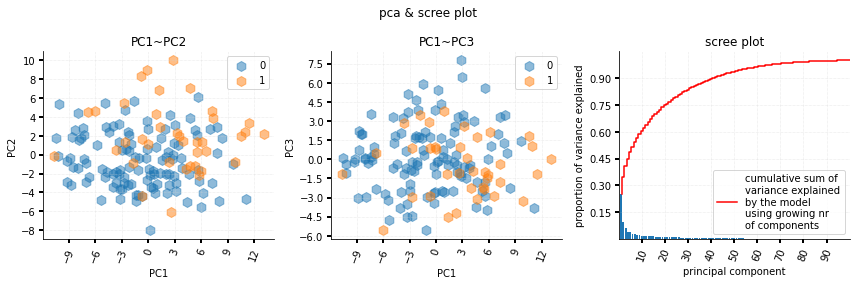


............................................................
 test0 - Step 1-5
............................................................



input    log log_filtered  \
sample nr                                              40     40           40   
gene nr                                             31085  31085        18555   
- VALUES -                                                                      
min tpm value recorded                                0.0    0.0          0.0   
median tpm value recorded                             0.3    0.4          2.9   
mean tpm value recorded                              32.2    1.8          3.1   
max tpm value recorded                            89880.5   16.5         16.5   
- DETECTED IN -                                                                 
mean % of genes expressed per sample                59.6%  59.6%        95.2%   
% of genes not expressed in any sample              23.1%  23.1%         0.0%   
% of genes expressed in at least 50%  of samples    59.2%  59.2%        98.6%   
% of genes expressed in all samples                 45.8%  45.8%        76.7%   

                                                 log_filtered_scaled  \
sample nr                                                         40   
gene nr                                                        18555   
- VALUES -                                                             
min tpm value recorded                                          -5.9   
median tpm value recorded                                       -0.0   
mean tpm value recorded                                          0.1   
max tpm value recorded                                         289.5   
- DETECTED IN -                                                        
mean % of genes expressed per sample                          100.0%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples              100.0%   
% of genes expressed in all samples                           100.0%   

                                                 outliers_removed top_genes  \
sample nr                                                      40        40   
gene nr                                                     18555       109   
- VALUES -                                                                    
min tpm value recorded                                       -5.9      -3.3   
median tpm value recorded                                    -0.0       0.0   
mean tpm value recorded                                       0.1       0.1   
max tpm value recorded                                      289.5       8.5   
- DETECTED IN -                                                               
mean % of genes expressed per sample                       100.0%    100.0%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples           100.0%    100.0%   
% of genes expressed in all samples                        100.0%    100.0%   

                                                 after pca  
sample nr                                               40  
gene nr                                                109  
- VALUES -                                                  
min tpm value recorded                                -5.1  
median tpm value recorded                             -0.0  
mean tpm value recorded                                0.0  
max tpm value recorded                                 7.6  
- DETECTED IN -                                             
mean % of genes expressed per sample                100.0%  
% of genes not expressed in any sample                0.0%  
% of genes expressed in at least 50%  of samples    100.0%  
% of genes expressed in all samples                 100.0%


............................................................
 test1 - Step 1-5
............................................................



input    log  \
sample nr                                               98     98   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.4   
mean tpm value recorded                               32.2    1.8   
max tpm value recorded                            133685.0   17.0   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 60.4%  60.4%   
% of genes not expressed in any sample               19.6%  19.6%   
% of genes expressed in at least 50%  of samples     60.0%  60.0%   
% of genes expressed in all samples                  45.6%  45.6%   

                                                 log_filtered  \
sample nr                                                  98   
gene nr                                                 18555   
- VALUES -                                                      
min tpm value recorded                                    0.0   
median tpm value recorded                                 2.9   
mean tpm value recorded                                   3.1   
max tpm value recorded                                   17.0   
- DETECTED IN -                                                 
mean % of genes expressed per sample                    96.0%   
% of genes not expressed in any sample                   0.0%   
% of genes expressed in at least 50%  of samples        99.4%   
% of genes expressed in all samples                     76.4%   

                                                 log_filtered_scaled  \
sample nr                                                         98   
gene nr                                                        18555   
- VALUES -                                                             
min tpm value recorded                                          -7.1   
median tpm value recorded                                        0.0   
mean tpm value recorded                                          0.1   
max tpm value recorded                                         188.2   
- DETECTED IN -                                                        
mean % of genes expressed per sample                          100.0%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples              100.0%   
% of genes expressed in all samples                           100.0%   

                                                 outliers_removed top_genes  \
sample nr                                                      98        98   
gene nr                                                     18555       109   
- VALUES -                                                                    
min tpm value recorded                                       -7.1      -3.1   
median tpm value recorded                                     0.0       0.0   
mean tpm value recorded                                       0.1       0.1   
max tpm value recorded                                      188.2      10.6   
- DETECTED IN -                                                               
mean % of genes expressed per sample                       100.0%    100.0%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples           100.0%    100.0%   
% of genes expressed in all samples                        100.0%    100.0%   

                                                 after pca  
sample nr                                               98  
gene nr                                                109  
- VALUES -                                                  
min tpm value recorded                                -7.1  
median tpm value recorded              



----------------------------------------

train data ...
df1 shape:  (152, 109)
df2 shape:  (152, 50)
final df:  (152, 159)

validation data ...
df1 shape:  (40, 109)
df2 shape:  (40, 50)
final df:  (40, 159)

test data ...
df1 shape:  (98, 109)
df2 shape:  (98, 50)
final df:  (98, 159)
----------------------------------------


PWD:  /Users/pawel/Desktop/activities/100__Projects/Ardigen/Ardigen/data/interim
SAVED:  Signif_genes_PCA_v2__transf_data_dct.p
SAVED:  Signif_genes_PCA_v2__qc_reports_dct.p


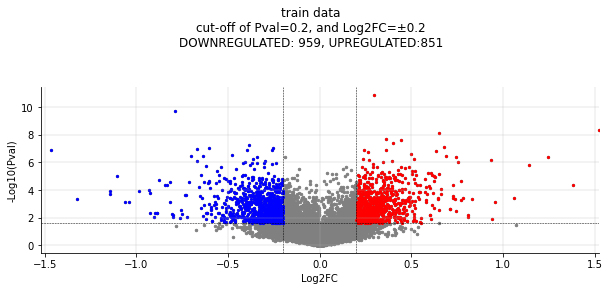


............................................................
 train - Step 1-5
............................................................



input    log  \
sample nr                                              160    160   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.4   
mean tpm value recorded                               32.2    1.8   
max tpm value recorded                            314419.1   18.3   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 60.2%  60.2%   
% of genes not expressed in any sample               18.1%  18.1%   
% of genes expressed in at least 50%  of samples     59.7%  59.7%   
% of genes expressed in all samples                  44.5%  44.5%   

                                                 log_filtered  \
sample nr                                                 160   
gene nr                                                 18555   
- VALUES -                                                      
min tpm value recorded                                    0.0   
median tpm value recorded                                 2.9   
mean tpm value recorded                                   3.1   
max tpm value recorded                                   18.3   
- DETECTED IN -                                                 
mean % of genes expressed per sample                    95.9%   
% of genes not expressed in any sample                   0.0%   
% of genes expressed in at least 50%  of samples       100.0%   
% of genes expressed in all samples                     74.5%   

                                                 log_filtered_scaled  \
sample nr                                                        160   
gene nr                                                        18555   
- VALUES -                                                             
min tpm value recorded                                          -9.4   
median tpm value recorded                                        0.0   
mean tpm value recorded                                          0.1   
max tpm value recorded                                         301.8   
- DETECTED IN -                                                        
mean % of genes expressed per sample                          100.0%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples              100.0%   
% of genes expressed in all samples                           100.0%   

                                                 outliers_removed top_genes  \
sample nr                                                     152       152   
gene nr                                                     18555      1810   
- VALUES -                                                                    
min tpm value recorded                                       -9.4      -5.1   
median tpm value recorded                                     0.0      -0.0   
mean tpm value recorded                                       0.1       0.1   
max tpm value recorded                                      226.7     173.0   
- DETECTED IN -                                                               
mean % of genes expressed per sample                       100.0%    100.0%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples           100.0%    100.0%   
% of genes expressed in all samples                        100.0%    100.0%   

                                                 after pca  
sample nr                                              152  
gene nr                                                152  
- VALUES -                                                  
min tpm value recorded                               -48.3  
median tpm value recorded              

............................................................
SIMILARITY BEWEEN SAMPLES
BASED ON GENE EXPRESSION IN THE TOP 1810 
differencially expressed genes
............................................................


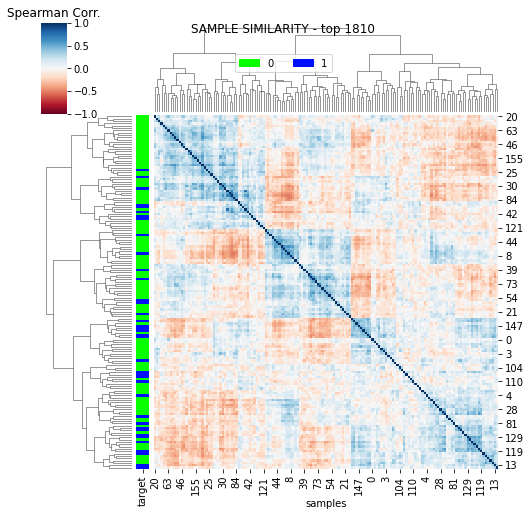

............................................................
GENE EXPRESSION IN THE TOP 
 1810 differencially expressed genes
............................................................


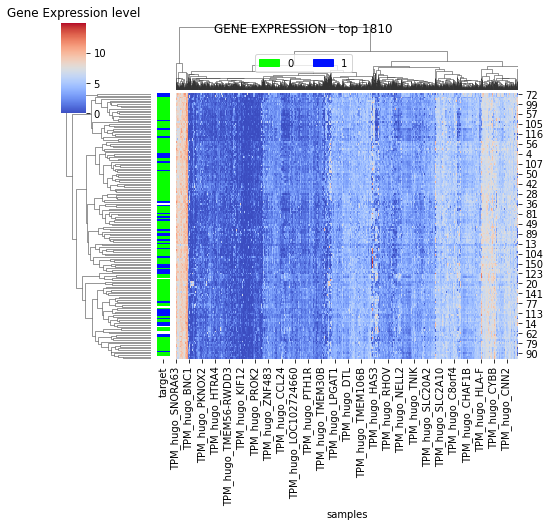

............................................................
PCA and tSNE analysis
............................................................


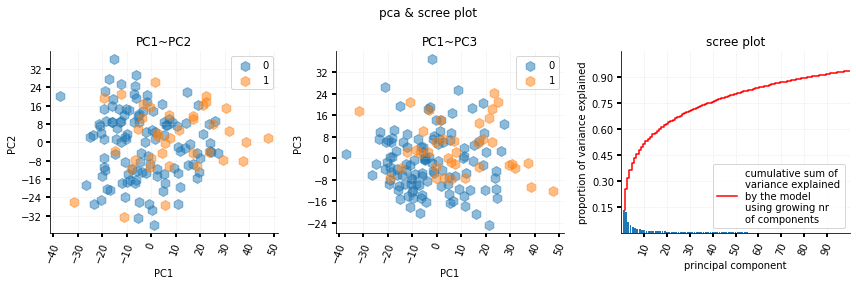


............................................................
 test0 - Step 1-5
............................................................



input    log log_filtered  \
sample nr                                              40     40           40   
gene nr                                             31085  31085        18555   
- VALUES -                                                                      
min tpm value recorded                                0.0    0.0          0.0   
median tpm value recorded                             0.3    0.4          2.9   
mean tpm value recorded                              32.2    1.8          3.1   
max tpm value recorded                            89880.5   16.5         16.5   
- DETECTED IN -                                                                 
mean % of genes expressed per sample                59.6%  59.6%        95.2%   
% of genes not expressed in any sample              23.1%  23.1%         0.0%   
% of genes expressed in at least 50%  of samples    59.2%  59.2%        98.6%   
% of genes expressed in all samples                 45.8%  45.8%        76.7%   

                                                 log_filtered_scaled  \
sample nr                                                         40   
gene nr                                                        18555   
- VALUES -                                                             
min tpm value recorded                                          -5.9   
median tpm value recorded                                       -0.0   
mean tpm value recorded                                          0.1   
max tpm value recorded                                         289.5   
- DETECTED IN -                                                        
mean % of genes expressed per sample                          100.0%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples              100.0%   
% of genes expressed in all samples                           100.0%   

                                                 outliers_removed top_genes  \
sample nr                                                      40        40   
gene nr                                                     18555      1810   
- VALUES -                                                                    
min tpm value recorded                                       -5.9      -5.4   
median tpm value recorded                                    -0.0      -0.0   
mean tpm value recorded                                       0.1       0.1   
max tpm value recorded                                      289.5      61.0   
- DETECTED IN -                                                               
mean % of genes expressed per sample                       100.0%    100.0%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples           100.0%    100.0%   
% of genes expressed in all samples                        100.0%    100.0%   

                                                 after pca  
sample nr                                               40  
gene nr                                                152  
- VALUES -                                                  
min tpm value recorded                               -27.7  
median tpm value recorded                              0.0  
mean tpm value recorded                                0.1  
max tpm value recorded                               102.8  
- DETECTED IN -                                             
mean % of genes expressed per sample                100.0%  
% of genes not expressed in any sample                0.0%  
% of genes expressed in at least 50%  of samples    100.0%  
% of genes expressed in all samples                 100.0%


............................................................
 test1 - Step 1-5
............................................................



input    log  \
sample nr                                               98     98   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.4   
mean tpm value recorded                               32.2    1.8   
max tpm value recorded                            133685.0   17.0   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 60.4%  60.4%   
% of genes not expressed in any sample               19.6%  19.6%   
% of genes expressed in at least 50%  of samples     60.0%  60.0%   
% of genes expressed in all samples                  45.6%  45.6%   

                                                 log_filtered  \
sample nr                                                  98   
gene nr                                                 18555   
- VALUES -                                                      
min tpm value recorded                                    0.0   
median tpm value recorded                                 2.9   
mean tpm value recorded                                   3.1   
max tpm value recorded                                   17.0   
- DETECTED IN -                                                 
mean % of genes expressed per sample                    96.0%   
% of genes not expressed in any sample                   0.0%   
% of genes expressed in at least 50%  of samples        99.4%   
% of genes expressed in all samples                     76.4%   

                                                 log_filtered_scaled  \
sample nr                                                         98   
gene nr                                                        18555   
- VALUES -                                                             
min tpm value recorded                                          -7.1   
median tpm value recorded                                        0.0   
mean tpm value recorded                                          0.1   
max tpm value recorded                                         188.2   
- DETECTED IN -                                                        
mean % of genes expressed per sample                          100.0%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples              100.0%   
% of genes expressed in all samples                           100.0%   

                                                 outliers_removed top_genes  \
sample nr                                                      98        98   
gene nr                                                     18555      1810   
- VALUES -                                                                    
min tpm value recorded                                       -7.1      -5.1   
median tpm value recorded                                     0.0       0.0   
mean tpm value recorded                                       0.1       0.1   
max tpm value recorded                                      188.2      77.2   
- DETECTED IN -                                                               
mean % of genes expressed per sample                       100.0%    100.0%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples           100.0%    100.0%   
% of genes expressed in all samples                        100.0%    100.0%   

                                                 after pca  
sample nr                                               98  
gene nr                                                152  
- VALUES -                                                  
min tpm value recorded                               -23.7  
median tpm value recorded              



----------------------------------------

train data ...
df1 shape:  (152, 152)
df2 shape:  (152, 50)
final df:  (152, 202)

validation data ...
df1 shape:  (40, 152)
df2 shape:  (40, 50)
final df:  (40, 202)

test data ...
df1 shape:  (98, 152)
df2 shape:  (98, 50)
final df:  (98, 202)
----------------------------------------


PWD:  /Users/pawel/Desktop/activities/100__Projects/Ardigen/Ardigen/data/interim
SAVED:  DE_genes_PCA_v2__transf_data_dct.p
SAVED:  DE_genes_PCA_v2__qc_reports_dct.p


In [22]:
# create test/validation dataset

n = 40
path = PATH_data_interim
random_nr = 2

# . set seed
np.random.seed(random_nr)

# . create idx, for test/valid datasets
idx_list = list(range(target.shape[0]))
np.random.shuffle(idx_list)
valid_idx = idx_list[0:n]; print(len(valid_idx))
train_idx = idx_list[n:200]; print(len(train_idx))

# . hand made methods - I had some issues with indexes
data_genes_train = data_genes.iloc[train_idx,:]
data_genes_train.reset_index(inplace=True, drop=True)
target_train = target.iloc[train_idx]
target_train.reset_index(inplace=True, drop=True)
data_cov_train = data_cov.iloc[train_idx,:]
data_cov_train.reset_index(inplace=True, drop=True)

# . validation 
data_genes_valid = data_genes.iloc[valid_idx,:]
data_genes_valid.reset_index(inplace=True, drop=True)
target_valid = target.iloc[valid_idx]
target_valid.reset_index(inplace=True, drop=True)
data_cov_valid = data_cov.iloc[valid_idx,:]
data_cov_valid.reset_index(inplace=True, drop=True)

# . run preprocessing pipeline
for data_set_name in list(parameters.keys()):

    transf_data, qc_reports = data_preprocessing_pipeline(
        # ..
        x_train=data_genes_train,
        y_train=target_train,
        cov=data_cov_train,
        cov_data_preprocessor=preprocessor,
        # ..
        x_test_list = [data_genes_valid, data_genes_test],
        y_test_list = [target_valid, None],
        cov_list = [data_cov_valid, data_cov_test],
        # ...
        verbose=1, 
        make_hist=True, 
        **parameters[data_set_name]
        ) 
    
    
    # check file dimensions by using my other function for merging files,

    
    print(f"\n\n{''.join(['-']*40)}")
    dataset_dct = transf_data
 
    print("\ntrain data ...")
    x_train = merge_data(dataset_dct["tpm_data"]["train"], dataset_dct["covariants_data"]["train"])
    y_train = dataset_dct['target_data']["train"]

    print("\nvalidation data ...")
    x_valid = merge_data(dataset_dct["tpm_data"]["test0"], dataset_dct["covariants_data"]["test0"])
    y_valid = dataset_dct['target_data']["test0"]

    print("\ntest data ...")
    x_test = merge_data(dataset_dct["tpm_data"]["test1"], dataset_dct["covariants_data"]["test1"])
    print(f"{''.join(['-']*40)}\n\n")

    
    # save the results
    
    
    os.chdir(path)
    print("PWD: ", path)
    
    # . file name
    prefix = f'{data_set_name}_v{random_nr}'
    
    # . save pickle - its fast, but dont use if you dont trust 
    fname = f"{prefix}__transf_data_dct.p"
    with open(fname, 'wb') as file: # wb - write binary,
                pickle.dump(transf_data, file) 
    print("SAVED: ", fname)

    # . save pickle - its fast, but dont use if you dont trust 
    fname = f"{prefix}__qc_reports_dct.p"
    with open(fname, 'wb') as file: # wb - write binary,
                pickle.dump(qc_reports, file) 
    print("SAVED: ", fname)
    

In [41]:
# ********************************************************************************** #
#                                                                                    #
#   Project: Ardigen task                                                            #                        
#   Author: Pawel Rosikiewicz                                                        #
#   Contact: prosikiewicz(a)gmail.com                                                #
#                                                                                    #
#   License: MIT License                                                             #
#   Copyright (C) 2022.06.04 Pawel Rosikiewicz                                       #
#                                                                                    #
# Permission is hereby granted, free of charge, to any person obtaining a copy       #
# of this software and associated documentation files (the "Software"), to deal      #
# in the Software without restriction, including without limitation the rights       #
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell          #
# copies of the Software, and to permit persons to whom the Software is              #
# furnished to do so, subject to the following conditions:                           #
#                                                                                    # 
# The above copyright notice and this permission notice shall be included in all     #
# copies or substantial portions of the Software.                                    #
#                                                                                    #
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR         #
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,           #
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE        #
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER             #
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,      #
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE      #
# SOFTWARE.                                                                          #
#                                                                                    #
# ********************************************************************************** #


#!/usr/bin/env python
# -*- coding: utf-8 -*-

import os
import sys
import re # module to use regular expressions, 
import glob # lists names in folders that match Unix shell patterns
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn import set_config
from sklearn.preprocessing import RobustScaler # creates custom transfomers
from sklearn.preprocessing import FunctionTransformer # creates custom transfomers
from sklearn.pipeline import make_pipeline, Pipeline # like pipeline function, but give step names automatically, 
from sklearn.compose import ColumnTransformer # allows using different transformers to different columns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer # skleanr transformers,
from sklearn.decomposition import PCA

# helper function for qc and piepline calibration
from src.utils.helper_tpm_summary import tpm_summary
from src.utils.helper_tpm_summary import tpm_plots
from src.utils.helper_cluster_histogram import spearman_clustermap
from src.utils.helper_boxplot import colored_boxplots
from src.utils.helper_colored_boxplot import plot_colored_boxplot
from src.utils.helper_gene_expression_clustermap import gene_expression_clustermap
from src.utils.helper_tpm_histogram import tpm_hist
from src.utils.helper_tpm_hist_per_gene import tpm_hist_per_gene
from src.utils.helper_PCA_plots import pca_plot_and_scree_plot
from src.utils.helper_PCA_plots import tsne_plot

# my custom transformers & gene seleciton tools
from src.utils.preprocessing_spearman_filter import SpearmanFilter # to remove sample outliers, 
from src.utils.preprocessing_zero_value_filter import ZeroValueFilter # to remove genes with no tpm in most of the samples
from src.utils.preprocessing_gene_selection_tools import compare_gene_expression 
from src.utils.preprocessing_gene_selection_tools import qc_for_selected_genes
from src.utils.preprocessing_gene_selection_tools import select_genes_and_make_volcano_plot



# -------------------------------------------------------------------------------------
# SECTION A. CUSTOM TRANSFORMERS
# -------------------------------------------------------------------------------------


# Function, .................................
def log_transformer(x):
    ''' log1p scaller for input dataframe (x)
        CAUTION: log1p returns runtime warning if negative data are used'''
    x = x.copy()
    x = x+1
    log_tr = make_pipeline( 
        FunctionTransformer(np.abs), # or else, you may get some errors, 
        FunctionTransformer(np.log2, validate=False),
    )
    x_log = pd.DataFrame(
        log_tr.fit_transform(x),
        columns=x.columns
    )
    return x_log


# Function, .................................
def rebuild_df(arr, dfdonor):
    '''takes an array, and tunrs into df, 
        with idx, and colnales form the donor
        . arr; numpy arr, 
        . df; pandas dataframe providing col/row names/indexes,
    '''
    df = pd.DataFrame(arr, columns=dfdonor.columns, index=dfdonor.index)
    return df


# Function, .................................
def rebuild_transposed_df(Tarr, dfdonor):
    '''takes an array, and tunrs into df, 
        with idx, and colnales form the donor
        . arr; numpy arr, 
        . df; pandas dataframe providing col/row names/indexes,
    '''
    df = pd.DataFrame(Tarr.T, columns=dfdonor.columns, index=dfdonor.index)
    return df




# -------------------------------------------------------------------------------------
# SECTION B. HELPER FUNCITONS FOR QC AND VERBOSE REPORTS
# -------------------------------------------------------------------------------------


# Function, ..............................................................................................
def make_tpm_summary(df_list, name_list=None):
    ''' PIPELINE HELPER FUNCTION
        Creates tpm cummary table for several dataframes provided in the list (df_list)
        colnames - list with columns names for new summary table 
        for more ifo see help for tpm_summary() 
    '''
    for i, df in enumerate(df_list):
        if i==0:
            summary_table = tpm_summary(df=df)
        else:
            summary_table =  pd.concat([summary_table, tpm_summary(df=df)])
    
    # transpose for nice looking output
    summary_table = summary_table.transpose() 
    
    # add column names corresponding to different df's
    if(name_list is not None):
        summary_table.columns=name_list
    else:
        summary_table.columns=list(range(len(df_list)))
    
    return summary_table
      
    
# Function, ..............................................................................................
def verbose_info(dtype, global_qc_report, x_samples_accepted, x_samples_removed, ttest_results, x_transf_deg, verbose=0):
    ''' PIPELINE HELPER FUNCTION
        small helper function to print-out messages for verbose 1 and 2
        for object description, please see DATA PREPROCESSING PIPLINE
    '''
    if verbose==1 or verbose==2:
        print(f'\n{"".join(["."]*60)}\n {dtype} - Step 1-5\n{"".join(["."]*60)}\n')
        display(global_qc_report)
            
        if verbose==2:
            print(f'\n OUTLIER REMOVAL')
            print(" ---- ACCEPTED", x_samples_accepted )
            print(" ---- REMOVED", x_samples_removed )     
            print(f'\n T-TEST RESULTS WIHT  TOP 10 GENES')                
            display(ttest_results.head(10))
            print(f'\n TRANFORMED INPUT DATA 10 GENES') 
            display(x_transf_deg.head(10))
        else:
            pass
    
    else:
        pass
    
    
# Function, ..............................................................................................
def plot_heatmaps_and_PCA_plots(deg_table, x_transf, y_transf, data_genes_log):
    ''' PIPELINE HELPER FUNCTION
        generates heatmasp with spearman_clustermap and gene_expression_clustermap funcitons,
        and pca plots on data prepared wiht te pipeline, 
        
        parameters
        . deg_table; pd. data frame with DE genes, selected by the pipeline
        . x_transf; pd. data frame with data from pipeline after step 4   
        . y_transf; pd. series frame with target variable, after step 4
        . data_genes_log; pd. data frame with log2p data
    '''
    
    # to silence error on depreciated function, 
    warnings.filterwarnings("ignore")
    
    a=True # legacy, from trials, 
    if a == True:
        # get gene names
        top_scores = deg_table.shape[0]
        gs_top =  deg_table.sort_values(by="Pval", ascending=False).index[0:top_scores]

        # crate spearma clustermap to see if these gene allows better separation between target classes
        title = f"SIMILARITY BEWEEN SAMPLES\nBASED ON GENE EXPRESSION IN THE TOP {top_scores} \ndifferencially expressed genes"
        print(f"{''.join(['.']*60)}\n{title}\n{''.join(['.']*60)}")
        
        # plot
        spearman_clustermap(
            df=x_transf.loc[:, gs_top.values.tolist()].transpose(), 
            labels=y_transf,  
            n=None, 
            figsize=(7,7),
            title=f"SAMPLE SIMILARITY - top {top_scores}"
        )

        # check if the selected gene "really" have different expression
        title = f"GENE EXPRESSION IN THE TOP \n {top_scores} differencially expressed genes"
        print(f"{''.join(['.']*60)}\n{title}\n{''.join(['.']*60)}")
        
        # plot
        gene_expression_clustermap(
            df=data_genes_log.loc[:, gs_top.values.tolist()], 
            labels=y_transf,  
            n=None, 
            figsize=(7,7),
            title=f"GENE EXPRESSION - top {top_scores}",
            cmap='coolwarm'
        )

        # get gene names
        title = f"PCA and tSNE analysis"
        print(f"{''.join(['.']*60)}\n{title}\n{''.join(['.']*60)}")
        
        # plots
        pca_plot_and_scree_plot(x_transf.loc[:, gs_top.values.tolist()], y_transf, scale="y")
    
    else:
        print("problem wiht heatmaps")
        
        
# Function, ..............................................................................................        
def create_sample_qc_table(sample_ID, x_samples_corr, cov_table):
    ''' PIPELINE HELPER FUNCTION
        generetas summary with ampout of missing data, and corr, at each sample in covariance data, 
        make sure that you removed outliers in x_corr results, for train data
        . x_samples_corr, x_log_filtered, cov_table; data frames, their names 
          correspond to objects used in  DATA PREPROCESSING PIPLINE
    '''
    # copy
    ct = cov_table.copy()
    x_corr = x_samples_corr.copy()
        
    # build table
    res = pd.concat([
        sample_ID,
        ct.isnull().sum(axis=1)/ct.shape[0],
        x_corr
    ], axis=1)
        
    # add column names & return
    res.columns=['sample_ID', 'no_tpm_prop', "spearman_corr"]
    return res



# -------------------------------------------------------------------------------------
# SECTION C. DATA PREPROCESSING PIPELINE
# -------------------------------------------------------------------------------------

# Function, .............................................................................................. 
def data_preprocessing_pipeline(
    x_train, y_train, cov, cov_data_preprocessor, x_test_list=None, y_test_list=None, cov_list=None, 
    zv_filter_dct=dict(), sp_filter_dct=dict(), select_genes_dct=dict(), 
    verbose=0, pca_n_components=0, make_hist=False):
    ''' This my full preprocessing pipeline, that is fully described in notebook introduction, 
        in short, it formats tpm data, removes genes with too much missing inf (ie. tmp==0), 
        removes outliers, with spearman filter, identifies differentialy expressed genes, perfomrs PCA, 
        and reports results wiht plots, histograms and tables, that i created in notebook 02

        parameters:
        . x_train, pd.DataFrame with tpm data
        . y_train, pd Series, with target data
        . cov, pd.dataframe, with covariants data
        . cov_data_preprocessor, skleanr preprocessor for cov.
        . ...
        . x_test_list, list with pd.DataFrame with tpm data tables, for test and validation datasets
        . y_test_list=None, -||- with target data for test/validation, None, if not used
        . cov_list=None, , -||- with cov tables for test and validation 
        . ...
        . zv_filter_dct=dict(), parameters, for ZeroValueFilter() # custom build for the project 
        . sp_filter_dct=dict(), -||- for SpearmanFilter() # custom build for the project 
        . select_genes_dct=dict(), -|| for DE genes selection, on Pval, and Log2FC
        . pca_n_components=0, if 0, no PCA, if None, or int, it performs pca
        . make_hist; if True, it provides histograms, as in the notebook 02, for selected genes, 
        . ...
        . verbose, if 1, it provides basic info, if 2 it provides additional tables 
            form selection steps, for debugging
        
        returns:
        . data dict with transfomed x_tains, y_train, and cos table, each in dict for train, and test0-n
        . qc dict, with reports on global qc selection process, gene and sample qc, in the final datasets, 
        + plots mentioned in abstract

    '''

    # - instanciate transformers ........................................... 
    robust_scaler = RobustScaler() 
    #robust_scaler =  QuantileTransformer(output_distribution='normal')
    zv_filter = ZeroValueFilter() # custom build for the project 
    sp_filter = SpearmanFilter() # custom build for the project 
    
    # - instanciate pca - optional
    if pca_n_components is None: 
        pca = PCA(n_components=None)
        use_pca = True
    else:
        if pca_n_components>0: 
            pca = PCA(n_components=pca_n_components)
            use_pca = True
        if pca_n_components==0: 
            use_pca = False
    
    # create lists for qc data and the datasets
    tpm_data = dict()
    target_data = dict()
    covariants_data = dict()
    
    # qc
    global_qc = dict()
    sample_qc = dict()
    gene_qc = dict()
    
    # verbose options
    if verbose==1 or verbose==2:
        select_genes_dct['create_plot']=True
        select_genes_dct['title']= f"train data"
    else:
        select_genes_dct['create_plot']=False
    
    
    # - process train data ...........................................

    # setup
    
    # . work on df copy,
    x, y =  x_train.copy(), y_train.copy()  
    cov_table =  cov.copy()  
    
    
    # pipeline - part 1 - data cleaning
    
    # . step 1. log1p to combat heteroscedascity,
    x_log = log_transformer(x)
    x_log = rebuild_df(x_log, x)
    # ... reset index 
    x_log.reset_index(drop=True, inplace=True)
    
    # . step 2. remove genes with too much na and noise, 
    x_log_filtered = zv_filter.fit_transform(x_log, **zv_filter_dct)

    # . step 3. apply  to results from each sample
    x_log_filtered_scaled = robust_scaler.fit_transform(x_log_filtered)
    x_log_filtered_scaled = rebuild_df(x_log_filtered_scaled, x_log_filtered)    
    # ... reset index 
    x_log_filtered_scaled.reset_index(drop=True, inplace=True)
    
    # . step 4. remove potential outliers from train data
    x_transf, y_transf = sp_filter.fit_transform(
        x=x_log_filtered_scaled, 
        y=y, 
        **sp_filter_dct
        )
    x_samples_removed = sp_filter._train_samples_removed
    x_samples_accepted = sp_filter._train_samples_accepted
    x_samples_corr = sp_filter._train_samples_corr
    
    if verbose==1 or verbose==2:    
        print("\ntrain data: outlier removal step") # added because I had problems with these thresholds
        print("REMOVED",x_samples_removed)
        print("ACCEPTED",x_samples_accepted,"\n")
    else:
        pass
    
    # ... reset indexes
    x_transf.reset_index(drop=True, inplace=True)  
    y_transf.reset_index(drop=True, inplace=True)  

    # ... remove outliers from covarinats table
    cov_table = cov_table.iloc[x_samples_accepted, :]
    cov_table.reset_index(drop=True, inplace=True)        
        
      
    # pipeline - part 2 - DE Gene Selection
    
    # . prepare log(tmp) file for DE analysis (not, x_tranf !)
    de_x = x_log_filtered.iloc[x_samples_accepted,:]
    de_x.reset_index(drop=True, inplace=True)  
    
    # . find diff. expressed genes & store qc data
    ttest_results = compare_gene_expression(x=de_x, y=y_transf, method="mean")
    ttest_results_qc = qc_for_selected_genes(
        tpm_data=x_log, 
        target_var=y, 
        gene_list=ttest_results.index.values.tolist(), 
        )
    ttest_results = pd.concat([ttest_results, ttest_results_qc], axis=1)
    deg_table = select_genes_and_make_volcano_plot(
      ttest_results, **select_genes_dct) # potential breaking point - if no genes meet criteria

    # . subset the data in x_tranf and (selected by column name)
    x_transf_deg =  x_transf.loc[:,deg_table.index.values.tolist()]
    x_transf_deg.reset_index(inplace=True, drop=True)

    
    # pipeline - part 3A - PCA
    if use_pca==True:
        pca.fit(x_transf_deg)
        x_components = pca.transform(x_transf_deg)   
        x_components = pd.DataFrame(x_components)
        x_components.reset_index(drop=True, inplace=True)
    else:
        x_components = x_transf_deg
  
  
    # pipeline - part 3B - covariant data preprocessor
    cov_table_transf = cov_data_preprocessor.fit_transform(cov_table)
    cov_table_transf = pd.DataFrame(cov_table_transf)
    cov_table_transf.reset_index(inplace=True, drop=True)

    
    # pipeline - part 4 - store the data
    tpm_data["train"] = x_components
    target_data["train"] = y_transf 
    covariants_data["train"] = cov_table_transf
    
    
    # pipeline - part 5 QC & info

    # . global_qc
    global_qc_report = make_tpm_summary(
        df_list=[x, x_log, x_log_filtered,  x_log_filtered_scaled, x_transf, x_transf_deg, x_components],
        name_list=['input', 'log', 'log_filtered',  'log_filtered_scaled', 
                   'outliers_removed', 'top_genes', "after pca"]
        )     
    sample_qc_report = create_sample_qc_table(
        sample_ID = pd.Series(x_samples_accepted),
        x_samples_corr = x_samples_corr.iloc[x_samples_accepted], 
        cov_table = cov_table
    )

    # . collect data qc
    global_qc[f"train"]=global_qc_report
    sample_qc[f"train"]=sample_qc_report
    gene_qc[f"train"]=deg_table    # i need to do second version for one table  

    # . verbose
    verbose_info("train", global_qc_report, x_samples_accepted, 
                 x_samples_removed, ttest_results, x_transf_deg, verbose=verbose)
    
    # . create hist, that will help you visualize whether selected genes are good, 
    if make_hist==True:
        plot_heatmaps_and_PCA_plots(
            deg_table = deg_table, 
            x_transf = x_transf, 
            y_transf = y_transf, 
            data_genes_log = x_log
        )
    else:
        pass

    # - process test & validation data ...........................................
    for i, x_te, y_te, cov_table in zip(list(range(len(x_test_list))), x_test_list, y_test_list, cov_list):

        # setup
        
        # . work on df copy,
        x, cov_table =  x_te.copy(), cov_table.copy()   
        
        # . test data not always have target variable 
        if y_te is None: y=pd.Series(["uknownw"]*x_te.shape[0])
        else: y=y_te.copy()
        
        # define verbose options
        if verbose==1 or verbose==2: 
            select_genes_dct['title']= f"test data {i}"
        else:
            pass
    
        # pipeline - part 1 - data cleaning

        # . step 1. log1p to combat heteroscedascity,
        x_log = log_transformer(x)
        x_log = rebuild_df(x_log, x)
        x_log.reset_index(drop=True, inplace=True)

        # . step 2. remove genes with too much na and noise, ---------
        x_log_filtered = zv_filter.transform(x_log)
        x_log_filtered.reset_index(drop=True, inplace=True)

        # . step 3. apply  to results from each sample
        x_log_filtered_scaled = robust_scaler.transform(x_log_filtered)
        x_log_filtered_scaled = rebuild_df(x_log_filtered_scaled, x_log_filtered)
        x_log_filtered_scaled.reset_index(drop=True, inplace=True)
        
        # . step 4. remove potential outliers from train data
        '''IN TRANSFORM, WE DO NOT REMOVE OUTLIERS, BUTT WE CHECK THEIR QUALITY'''
        x_transf, y_transf = x_log_filtered_scaled, y
        _ , _ = sp_filter.transform(
            x=x_log_filtered_scaled, 
            y=pd.Series(y), 
            inform = True
            )
        x_samples_removed = sp_filter._test_samples_removed
        x_samples_accepted = sp_filter._test_samples_accepted
        x_samples_corr = sp_filter._test_samples_corr
        
        # ...
        x_samples_corr.reset_index(drop=True, inplace=True)
        x_transf.reset_index(drop=True, inplace=True)
        y_transf.reset_index(drop=True, inplace=True)

        
        # pipeline - part 2
        '''in test samples we are using log files directly, no samples are removed'''
        
        
        # . select DE genes, based on train data, 
        """subset the data in x_tranf with pre-selected genes from train data"""
        genes_to_subset = gene_qc["train"].index.values.tolist()
        x_transf_deg =  x_transf.loc[:,genes_to_subset]
        x_transf_deg.reset_index(drop=True, inplace=True)
      
        # pipeline - part 3A - PCA
        if use_pca==True:
            x_components = pca.transform(x_transf_deg)   
            x_components = pd.DataFrame(x_components)
            x_components.reset_index(drop=True, inplace=True)
        else:
            x_components = x_transf_deg       

            
        # pipeline - part 3B - covarinat data preprocessor
        cov_table_transf = cov_data_preprocessor.transform(cov_table)
        cov_table_transf = pd.DataFrame(cov_table_transf)
        cov_table_transf.reset_index(drop=True, inplace=True)
    
    
        # pipeline - part 4 - store the data
        tpm_data[f"test{i}"] = x_components
        target_data[f"test{i}"] = y_transf 
        covariants_data[f"test{i}"] = cov_table_transf # no modificaiton in test data   

        
        # pipeline - part 5 - QC
        
        # . global_qc
        global_qc_report = make_tpm_summary(
            df_list=[x, x_log, x_log_filtered,  x_log_filtered_scaled, x_transf, x_transf_deg, x_components],
            name_list=['input', 'log', 'log_filtered',  'log_filtered_scaled', 'outliers_removed', 'top_genes', "after pca"]
            )
        sample_qc_report = create_sample_qc_table(
            sample_ID = pd.Series(np.arange(cov_table.shape[0])),
            x_samples_corr = x_samples_corr, 
            cov_table = cov_table
        )
     
        # . colect reports
        global_qc[f"test{i}"]=global_qc_report
        sample_qc[f"test{i}"]=sample_qc_report
        gene_qc[f"test{i}"]=None # not done, because it was a trouble, with making alternative function - out of the scope for that task        
        
        # . verbose
        verbose_info(f"test{i}",global_qc_report, x_samples_accepted, x_samples_removed, ttest_results, x_transf_deg, verbose=verbose)

    # COLLECT ALL RESULTS
    data = {
        "tpm_data" : tpm_data,
        "target_data" : target_data, 
        "covariants_data" : covariants_data
        }
    qc = {
        "global_qc" : global_qc,
        "sample_qc" : sample_qc, 
        "gene_qc" : gene_qc
        }
    
    return data, qc
        

In [29]:
# ********************************************************************************** #
#                                                                                    #
#   Project: Ardigen task                                                            #                        
#   Author: Pawel Rosikiewicz                                                        #
#   Contact: prosikiewicz(a)gmail.com                                                #
#                                                                                    #
#   License: MIT License                                                             #
#   Copyright (C) 2022.06.04 Pawel Rosikiewicz                                       #
#                                                                                    #
# Permission is hereby granted, free of charge, to any person obtaining a copy       #
# of this software and associated documentation files (the "Software"), to deal      #
# in the Software without restriction, including without limitation the rights       #
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell          #
# copies of the Software, and to permit persons to whom the Software is              #
# furnished to do so, subject to the following conditions:                           #
#                                                                                    # 
# The above copyright notice and this permission notice shall be included in all     #
# copies or substantial portions of the Software.                                    #
#                                                                                    #
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR         #
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,           #
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE        #
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER             #
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,      #
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE      #
# SOFTWARE.                                                                          #
#                                                                                    #
# ********************************************************************************** #



#!/usr/bin/env python
# -*- coding: utf-8 -*-

import os # allow changing, and navigating files and folders, 
import sys
import re # module to use regular expressions, 
import glob # lists names in folders that match Unix shell patterns
import random # functions that use and generate random numbers

import numpy as np # support for multi-dimensional arrays and matrices
import pandas as pd # library for data manipulation and analysis
import seaborn as sns # advance plots, for statistics, 
import matplotlib as mpl # to get basic plt   functions, heping with plot mnaking 
import matplotlib.pyplot as plt # for making plots, 



class SpearmanFilter():
    ''' .............................................................
        Custom made transformer for TMP data provided from RNAseq experiments
        .............................................................        
        Allows Rank-based filtering with Spearman correlation of samples on rnaseq data.
        * first it creates an average gene expression profile for all samples
        * then, it calulates speerman rho correlation coef, for each sample, and the mean profile
        * finally, it removes the samples, that are either below preset tthreshold, or at lower quantile, 
        * the threshold, methods, and averaging methods are parametrized  
        
        FUNCTIONS
        . fit_transform()    : see below fit transform policy
        . transform()        : see funciton for transfomed policy
    '''

    # (a) private methods and variables, 

    # Method,.....................................
    def __init__(self):
        
        # parametrs
        self._tr=None # its 1-speakerm corr. with the mean, sample 
        self._quantile=None
        self._method=None
        self._avg_menthod=None

        # train data
        self._train_mean_profile=None
        self._train_samples_corr=None
        self._train_samples_removed=None
        self._train_samples_accepted=None
        
        # test data
        self._test_samples_corr=None
        self._test_samples_removed=None
        self._test_samples_accepted=None        
    
    # (b) public methods
    
    # Method,.....................................
    def fit_transform(self, x, y, tr=0.95, quantile=True, method='spearman', avg_menthod="median"):
        ''' Allows Rank-based filtering with Spearman correlation of samples on rnaseq data.
            * first it creates an average gene expression profile for all samples
            * then, it calulates speerman rho correlation coef, for each sample, and the mean profile
            * finally, it removes the samples, that are either below preset tthreshold, or at lower quantile, 
            * the threshold, methods, and averaging methods are parametrized  
            
            parameters:
            . x; Pandas DataFrame
            . y; pandas Series
            . tr; float [0-1], if qunatile=False (see below) it will reject all samples we corr<tr, 
            . quantile; bool, if True, tr used to calulate lower quantile boudary for 1-tr 
            . method; str, eg: 'spearman', method from pandas.df.corr()
            . avg_menthod; str, "median", or "mean"
            
            returns:
            . trandsformed x; Pandas DataFrame
            . trandsformed y; pandas Series            
            
            comments:
            parameters used, and list of corr, results, and samples rejected and accepted are available as private variables, 
        '''
        
        # store threshold parameters,  
        self._tr=tr # may be modified later later, based on the quantile options
        self._quantile=quantile
        self._method=method
        self._avg_menthod=avg_menthod
        
        # Test input df,
        assert type(x) == pd.DataFrame, "Incorrect obj type: x shoudl be pd.Series"
        assert type(y) == pd.Series, "Incorrect obj type: y shoudl be pd.Series"

        # create average gen expression profile for train data
        if avg_menthod=="median":
            self._train_mean_profile = x.apply(np.median, axis=0)
        else:
            self._train_mean_profile = x.apply(np.mean, axis=0)
        train_mean_profile = self._train_mean_profile
            
            
        # calulate spearman corr between each sample, and avg_profile
        ''' done with for lopp to avoid any error, 
            and becuase i have relatively small sample nr
        '''
        train_samples_corr=[]
        for index in range(x.shape[0]):
            # calulate corr.
            dftemp = pd.concat([x.iloc[index,:], train_mean_profile], axis=1)
            one_sample_corr = dftemp.corr(method=method).iloc[0,1]

            # store the results
            train_samples_corr.append(one_sample_corr)

        # keep corr results, and sample Id's inside pd series,
        train_samples_corr = pd.Series(train_samples_corr, index=x.index.values.tolist())
        self._train_samples_corr = train_samples_corr

        # find samples to remove and accept
        if quantile==False:
            '''threshold is used dirently, to filter the samples with corr results'''
            self._train_samples_removed = train_samples_corr.iloc[(train_samples_corr<tr).values.tolist()].index.values.tolist()
            self._train_samples_accepted = train_samples_corr.iloc[(train_samples_corr>=tr).values.tolist()].index.values.tolist()
        else:
            '''1-threshold is used as quantile value'''
            lower_quntile_tr = train_samples_corr.quantile(1-tr)
            self._train_samples_removed = train_samples_corr.iloc[(train_samples_corr<lower_quntile_tr).values.tolist()].index.values.tolist()
            self._train_samples_accepted = train_samples_corr.iloc[(train_samples_corr>=lower_quntile_tr).values.tolist()].index.values.tolist() 
            self._tr=lower_quntile_tr

        # remove rejected samples and return the data
        x_transf = x.iloc[self._train_samples_accepted,:]
        y_transf = y.iloc[self._train_samples_accepted]
        
        return x_transf, y_transf 
            
            
    # Method,.....................................
    def transform(self, x, y, inform=False):
        ''' transform method for Rank-based filtering with Spearman correlation of samples on rnaseq data.
            * first it creates an average gene expression profile for all samples
            * then, it calulates speerman rho correlation coef, for each sample, and the mean profile
            * finally, it removes the samples, that are either below preset tthreshold, or at lower quantile, 
            * the threshold, methods, and averaging methods are parametrized  
            
            parameters:
            . x; Pandas DataFrame
            . y; pandas Series
            . inform; bool; if True, fucntion will return pd.series with correlation vvalues only, 
            
            returns:
            . trandsformed x; Pandas DataFrame
            . trandsformed y; pandas Series            
            
            comments:
            parameters used, and list of corr, results, and samples rejected and accepted are available as private variables, 
        '''
        # store threshold parameters,  
        tr = self._tr
        quantile = self._quantile
        method = self._method
        avg_menthod = self._avg_menthod
        train_mean_profile = self._train_mean_profile
        
        # Test input df,
        assert type(x) == pd.DataFrame, "Incorrect obj type: x shoudl be pd.Series"
        assert type(y) == pd.Series, "Incorrect obj type: y shoudl be pd.Series"

        # calulate spearman corr between each sample, and avg_profile
        ''' done with for lopp to avoid any error, 
            and becuase i have relatively small sample nr
        '''
        test_samples_corr=[]
        for index in range(x.shape[0]):
            # calulate corr.
            dftemp = pd.concat([x.iloc[index,:], train_mean_profile], axis=1)
            one_sample_corr = dftemp.corr(method=method).iloc[0,1]

            # store the results
            test_samples_corr.append(one_sample_corr)

        # keep corr results, and sample Id's inside pd series,
        test_samples_corr = pd.Series(test_samples_corr, index=x.index.values.tolist())
        self._test_samples_corr = test_samples_corr

        # find samples to remove and accept
        '''in tranfomr the threshold is taken from fit_transform method'''
        self._test_samples_removed = test_samples_corr.iloc[(test_samples_corr<tr).values.tolist()].index.values.tolist()
        self._test_samples_accepted = test_samples_corr.iloc[(test_samples_corr>=tr).values.tolist()].index.values.tolist()

        # remove rejected samples and return the data
        x_transf = x.iloc[self._test_samples_accepted,:]
        y_transf = y.iloc[self._test_samples_accepted]
        
        if inform==False:
            return x_transf, y_transf 
        else:
            return self._train_samples_corr, self._test_samples_corr

In [ ]:
# parameters for data preparation
parameters = {
    'Signif_genes_Out':{
        'zv_filter_dct':dict(na_tr=0.5),
        'sp_filter_dct':dict(tr=-1, quantile=False),
        'select_genes_dct':dict(Log2FCtr=0.5, Ptr=0.05, create_plot=True),
        'pca_n_components':0
     },
    'Signif_genes_PCA_Out':{
        'zv_filter_dct':dict(na_tr=0.5),
        'sp_filter_dct':dict(tr=-1, quantile=False),
        'select_genes_dct':dict(Log2FCtr=0.5, Ptr=0.05, create_plot=True),
        'pca_n_components':None
     },    
    'DE_genes_PCA_Out':{
        'zv_filter_dct':dict(na_tr=0.5),
        'sp_filter_dct':dict(tr=-1, quantile=False),
        'select_genes_dct':dict(Log2FCtr=0.2, Ptr=0.2, create_plot=True),
        'pca_n_components':None
     }    
}

40
160

train data: outlier removal step
REMOVED []
ACCEPTED [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159] 



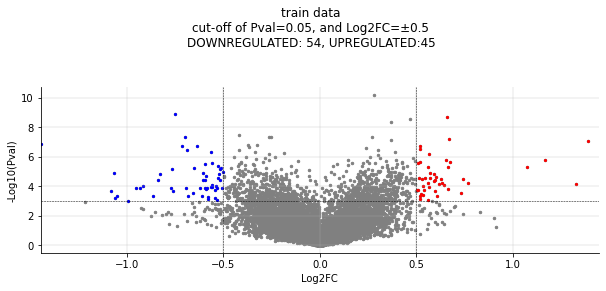


............................................................
 train - Step 1-5
............................................................



input    log  \
sample nr                                              160    160   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.4   
mean tpm value recorded                               32.2    1.8   
max tpm value recorded                            314419.1   18.3   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 60.2%  60.2%   
% of genes not expressed in any sample               18.1%  18.1%   
% of genes expressed in at least 50%  of samples     59.7%  59.7%   
% of genes expressed in all samples                  44.5%  44.5%   

                                                 log_filtered  \
sample nr                                                 160   
gene nr                                                 18555   
- VALUES -                                                      
min tpm value recorded                                    0.0   
median tpm value recorded                                 2.9   
mean tpm value recorded                                   3.1   
max tpm value recorded                                   18.3   
- DETECTED IN -                                                 
mean % of genes expressed per sample                    95.9%   
% of genes not expressed in any sample                   0.0%   
% of genes expressed in at least 50%  of samples       100.0%   
% of genes expressed in all samples                     74.5%   

                                                 log_filtered_scaled  \
sample nr                                                        160   
gene nr                                                        18555   
- VALUES -                                                             
min tpm value recorded                                          -9.4   
median tpm value recorded                                        0.0   
mean tpm value recorded                                          0.1   
max tpm value recorded                                         301.8   
- DETECTED IN -                                                        
mean % of genes expressed per sample                          100.0%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples              100.0%   
% of genes expressed in all samples                           100.0%   

                                                 outliers_removed top_genes  \
sample nr                                                     160       160   
gene nr                                                     18555        99   
- VALUES -                                                                    
min tpm value recorded                                       -9.4      -3.8   
median tpm value recorded                                     0.0       0.0   
mean tpm value recorded                                       0.1       0.1   
max tpm value recorded                                      301.8      21.0   
- DETECTED IN -                                                               
mean % of genes expressed per sample                       100.0%    100.0%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples           100.0%    100.0%   
% of genes expressed in all samples                        100.0%    100.0%   

                                                 after pca  
sample nr                                              160  
gene nr                                                 99  
- VALUES -                                                  
min tpm value recorded                                -8.1  
median tpm value recorded              

............................................................
SIMILARITY BEWEEN SAMPLES
BASED ON GENE EXPRESSION IN THE TOP 99 
differencially expressed genes
............................................................


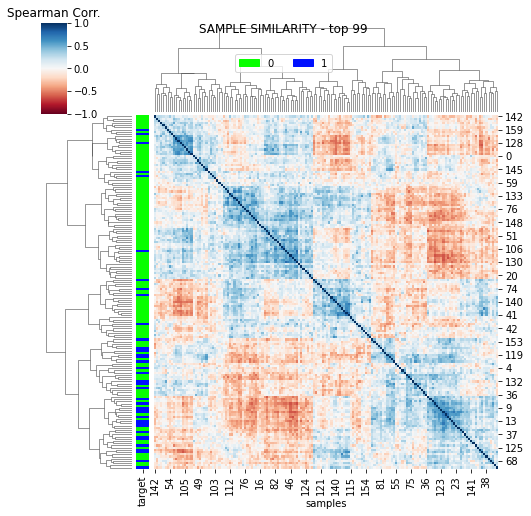

............................................................
GENE EXPRESSION IN THE TOP 
 99 differencially expressed genes
............................................................


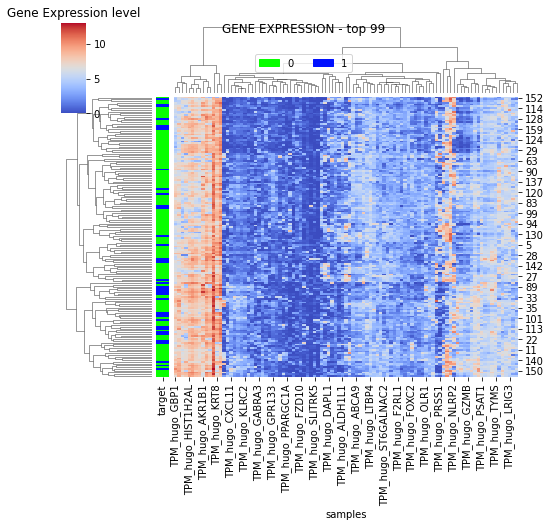

............................................................
PCA and tSNE analysis
............................................................


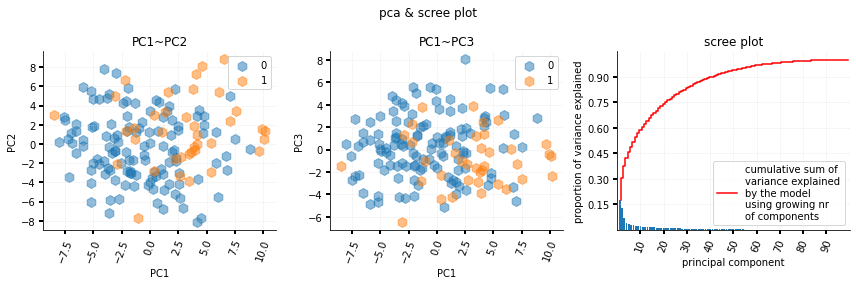


............................................................
 test0 - Step 1-5
............................................................



input    log log_filtered  \
sample nr                                              40     40           40   
gene nr                                             31085  31085        18555   
- VALUES -                                                                      
min tpm value recorded                                0.0    0.0          0.0   
median tpm value recorded                             0.3    0.4          2.9   
mean tpm value recorded                              32.2    1.8          3.1   
max tpm value recorded                            89880.5   16.5         16.5   
- DETECTED IN -                                                                 
mean % of genes expressed per sample                59.6%  59.6%        95.2%   
% of genes not expressed in any sample              23.1%  23.1%         0.0%   
% of genes expressed in at least 50%  of samples    59.2%  59.2%        98.6%   
% of genes expressed in all samples                 45.8%  45.8%        76.7%   

                                                 log_filtered_scaled  \
sample nr                                                         40   
gene nr                                                        18555   
- VALUES -                                                             
min tpm value recorded                                          -5.9   
median tpm value recorded                                       -0.0   
mean tpm value recorded                                          0.1   
max tpm value recorded                                         289.5   
- DETECTED IN -                                                        
mean % of genes expressed per sample                          100.0%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples              100.0%   
% of genes expressed in all samples                           100.0%   

                                                 outliers_removed top_genes  \
sample nr                                                      40        40   
gene nr                                                     18555        99   
- VALUES -                                                                    
min tpm value recorded                                       -5.9      -3.3   
median tpm value recorded                                    -0.0       0.0   
mean tpm value recorded                                       0.1       0.1   
max tpm value recorded                                      289.5       8.5   
- DETECTED IN -                                                               
mean % of genes expressed per sample                       100.0%    100.0%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples           100.0%    100.0%   
% of genes expressed in all samples                        100.0%    100.0%   

                                                 after pca  
sample nr                                               40  
gene nr                                                 99  
- VALUES -                                                  
min tpm value recorded                                -6.6  
median tpm value recorded                             -0.0  
mean tpm value recorded                               -0.0  
max tpm value recorded                                 6.7  
- DETECTED IN -                                             
mean % of genes expressed per sample                100.0%  
% of genes not expressed in any sample                0.0%  
% of genes expressed in at least 50%  of samples    100.0%  
% of genes expressed in all samples                 100.0%


............................................................
 test1 - Step 1-5
............................................................



input    log  \
sample nr                                               98     98   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.4   
mean tpm value recorded                               32.2    1.8   
max tpm value recorded                            133685.0   17.0   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 60.4%  60.4%   
% of genes not expressed in any sample               19.6%  19.6%   
% of genes expressed in at least 50%  of samples     60.0%  60.0%   
% of genes expressed in all samples                  45.6%  45.6%   

                                                 log_filtered  \
sample nr                                                  98   
gene nr                                                 18555   
- VALUES -                                                      
min tpm value recorded                                    0.0   
median tpm value recorded                                 2.9   
mean tpm value recorded                                   3.1   
max tpm value recorded                                   17.0   
- DETECTED IN -                                                 
mean % of genes expressed per sample                    96.0%   
% of genes not expressed in any sample                   0.0%   
% of genes expressed in at least 50%  of samples        99.4%   
% of genes expressed in all samples                     76.4%   

                                                 log_filtered_scaled  \
sample nr                                                         98   
gene nr                                                        18555   
- VALUES -                                                             
min tpm value recorded                                          -7.1   
median tpm value recorded                                        0.0   
mean tpm value recorded                                          0.1   
max tpm value recorded                                         188.2   
- DETECTED IN -                                                        
mean % of genes expressed per sample                          100.0%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples              100.0%   
% of genes expressed in all samples                           100.0%   

                                                 outliers_removed top_genes  \
sample nr                                                      98        98   
gene nr                                                     18555        99   
- VALUES -                                                                    
min tpm value recorded                                       -7.1      -3.1   
median tpm value recorded                                     0.0       0.0   
mean tpm value recorded                                       0.1       0.1   
max tpm value recorded                                      188.2      10.6   
- DETECTED IN -                                                               
mean % of genes expressed per sample                       100.0%    100.0%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples           100.0%    100.0%   
% of genes expressed in all samples                        100.0%    100.0%   

                                                 after pca  
sample nr                                               98  
gene nr                                                 99  
- VALUES -                                                  
min tpm value recorded                                -5.8  
median tpm value recorded              



----------------------------------------

train data ...
df1 shape:  (160, 99)
df2 shape:  (160, 50)
final df:  (160, 149)

validation data ...
df1 shape:  (40, 99)
df2 shape:  (40, 50)
final df:  (40, 149)

test data ...
df1 shape:  (98, 99)
df2 shape:  (98, 50)
final df:  (98, 149)
----------------------------------------


PWD:  /Users/pawel/Desktop/activities/100__Projects/Ardigen/Ardigen/data/interim
SAVED:  Signif_genes_PCA_Out_v2__transf_data_dct.p
SAVED:  Signif_genes_PCA_Out_v2__qc_reports_dct.p

train data: outlier removal step
REMOVED []
ACCEPTED [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108

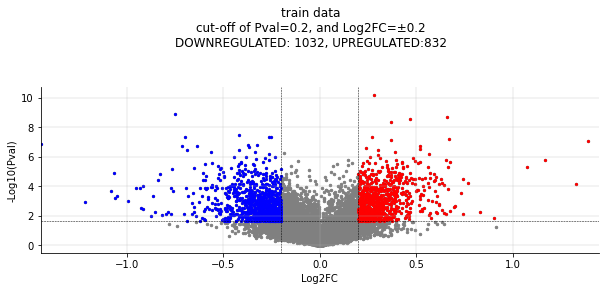


............................................................
 train - Step 1-5
............................................................



input    log  \
sample nr                                              160    160   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.4   
mean tpm value recorded                               32.2    1.8   
max tpm value recorded                            314419.1   18.3   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 60.2%  60.2%   
% of genes not expressed in any sample               18.1%  18.1%   
% of genes expressed in at least 50%  of samples     59.7%  59.7%   
% of genes expressed in all samples                  44.5%  44.5%   

                                                 log_filtered  \
sample nr                                                 160   
gene nr                                                 18555   
- VALUES -                                                      
min tpm value recorded                                    0.0   
median tpm value recorded                                 2.9   
mean tpm value recorded                                   3.1   
max tpm value recorded                                   18.3   
- DETECTED IN -                                                 
mean % of genes expressed per sample                    95.9%   
% of genes not expressed in any sample                   0.0%   
% of genes expressed in at least 50%  of samples       100.0%   
% of genes expressed in all samples                     74.5%   

                                                 log_filtered_scaled  \
sample nr                                                        160   
gene nr                                                        18555   
- VALUES -                                                             
min tpm value recorded                                          -9.4   
median tpm value recorded                                        0.0   
mean tpm value recorded                                          0.1   
max tpm value recorded                                         301.8   
- DETECTED IN -                                                        
mean % of genes expressed per sample                          100.0%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples              100.0%   
% of genes expressed in all samples                           100.0%   

                                                 outliers_removed top_genes  \
sample nr                                                     160       160   
gene nr                                                     18555      1864   
- VALUES -                                                                    
min tpm value recorded                                       -9.4      -5.1   
median tpm value recorded                                     0.0       0.0   
mean tpm value recorded                                       0.1       0.1   
max tpm value recorded                                      301.8     173.0   
- DETECTED IN -                                                               
mean % of genes expressed per sample                       100.0%    100.0%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples           100.0%    100.0%   
% of genes expressed in all samples                        100.0%    100.0%   

                                                 after pca  
sample nr                                              160  
gene nr                                                160  
- VALUES -                                                  
min tpm value recorded                               -41.8  
median tpm value recorded              

............................................................
SIMILARITY BEWEEN SAMPLES
BASED ON GENE EXPRESSION IN THE TOP 1864 
differencially expressed genes
............................................................


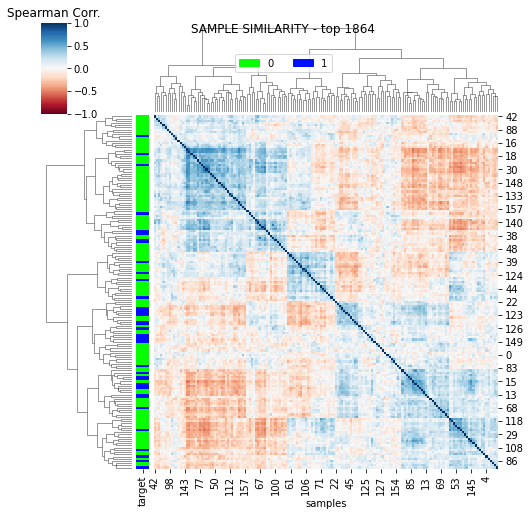

............................................................
GENE EXPRESSION IN THE TOP 
 1864 differencially expressed genes
............................................................


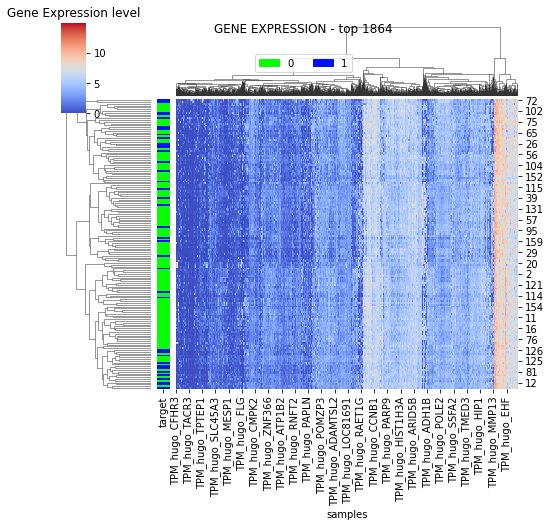

............................................................
PCA and tSNE analysis
............................................................


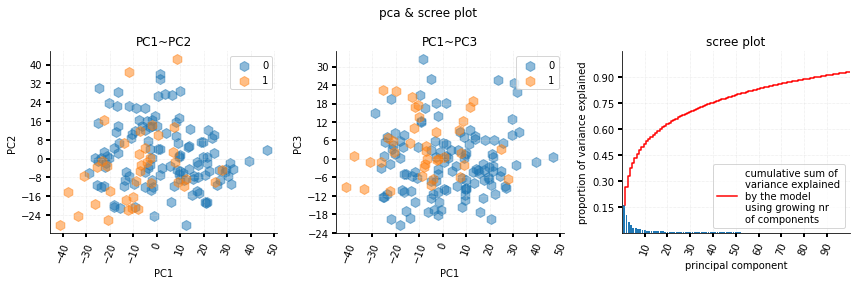


............................................................
 test0 - Step 1-5
............................................................



input    log log_filtered  \
sample nr                                              40     40           40   
gene nr                                             31085  31085        18555   
- VALUES -                                                                      
min tpm value recorded                                0.0    0.0          0.0   
median tpm value recorded                             0.3    0.4          2.9   
mean tpm value recorded                              32.2    1.8          3.1   
max tpm value recorded                            89880.5   16.5         16.5   
- DETECTED IN -                                                                 
mean % of genes expressed per sample                59.6%  59.6%        95.2%   
% of genes not expressed in any sample              23.1%  23.1%         0.0%   
% of genes expressed in at least 50%  of samples    59.2%  59.2%        98.6%   
% of genes expressed in all samples                 45.8%  45.8%        76.7%   

                                                 log_filtered_scaled  \
sample nr                                                         40   
gene nr                                                        18555   
- VALUES -                                                             
min tpm value recorded                                          -5.9   
median tpm value recorded                                       -0.0   
mean tpm value recorded                                          0.1   
max tpm value recorded                                         289.5   
- DETECTED IN -                                                        
mean % of genes expressed per sample                          100.0%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples              100.0%   
% of genes expressed in all samples                           100.0%   

                                                 outliers_removed top_genes  \
sample nr                                                      40        40   
gene nr                                                     18555      1864   
- VALUES -                                                                    
min tpm value recorded                                       -5.9      -5.4   
median tpm value recorded                                    -0.0      -0.0   
mean tpm value recorded                                       0.1       0.1   
max tpm value recorded                                      289.5      61.0   
- DETECTED IN -                                                               
mean % of genes expressed per sample                       100.0%    100.0%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples           100.0%    100.0%   
% of genes expressed in all samples                        100.0%    100.0%   

                                                 after pca  
sample nr                                               40  
gene nr                                                160  
- VALUES -                                                  
min tpm value recorded                               -32.1  
median tpm value recorded                             -0.0  
mean tpm value recorded                               -0.0  
max tpm value recorded                                90.3  
- DETECTED IN -                                             
mean % of genes expressed per sample                100.0%  
% of genes not expressed in any sample                0.0%  
% of genes expressed in at least 50%  of samples    100.0%  
% of genes expressed in all samples                 100.0%


............................................................
 test1 - Step 1-5
............................................................



input    log  \
sample nr                                               98     98   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.4   
mean tpm value recorded                               32.2    1.8   
max tpm value recorded                            133685.0   17.0   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 60.4%  60.4%   
% of genes not expressed in any sample               19.6%  19.6%   
% of genes expressed in at least 50%  of samples     60.0%  60.0%   
% of genes expressed in all samples                  45.6%  45.6%   

                                                 log_filtered  \
sample nr                                                  98   
gene nr                                                 18555   
- VALUES -                                                      
min tpm value recorded                                    0.0   
median tpm value recorded                                 2.9   
mean tpm value recorded                                   3.1   
max tpm value recorded                                   17.0   
- DETECTED IN -                                                 
mean % of genes expressed per sample                    96.0%   
% of genes not expressed in any sample                   0.0%   
% of genes expressed in at least 50%  of samples        99.4%   
% of genes expressed in all samples                     76.4%   

                                                 log_filtered_scaled  \
sample nr                                                         98   
gene nr                                                        18555   
- VALUES -                                                             
min tpm value recorded                                          -7.1   
median tpm value recorded                                        0.0   
mean tpm value recorded                                          0.1   
max tpm value recorded                                         188.2   
- DETECTED IN -                                                        
mean % of genes expressed per sample                          100.0%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples              100.0%   
% of genes expressed in all samples                           100.0%   

                                                 outliers_removed top_genes  \
sample nr                                                      98        98   
gene nr                                                     18555      1864   
- VALUES -                                                                    
min tpm value recorded                                       -7.1      -4.8   
median tpm value recorded                                     0.0       0.0   
mean tpm value recorded                                       0.1       0.1   
max tpm value recorded                                      188.2      77.2   
- DETECTED IN -                                                               
mean % of genes expressed per sample                       100.0%    100.0%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples           100.0%    100.0%   
% of genes expressed in all samples                        100.0%    100.0%   

                                                 after pca  
sample nr                                               98  
gene nr                                                160  
- VALUES -                                                  
min tpm value recorded                               -29.8  
median tpm value recorded              



----------------------------------------

train data ...
df1 shape:  (160, 160)
df2 shape:  (160, 50)
final df:  (160, 210)

validation data ...
df1 shape:  (40, 160)
df2 shape:  (40, 50)
final df:  (40, 210)

test data ...
df1 shape:  (98, 160)
df2 shape:  (98, 50)
final df:  (98, 210)
----------------------------------------


PWD:  /Users/pawel/Desktop/activities/100__Projects/Ardigen/Ardigen/data/interim
SAVED:  DE_genes_PCA_Out_v2__transf_data_dct.p
SAVED:  DE_genes_PCA_Out_v2__qc_reports_dct.p


In [42]:
# parameters for data preparation
parameters = {
    'Signif_genes_PCA_Out':{
        'zv_filter_dct':dict(na_tr=0.5),
        'sp_filter_dct':dict(tr=-1, quantile=False),
        'select_genes_dct':dict(Log2FCtr=0.5, Ptr=0.05, create_plot=True),
        'pca_n_components':None
     },    
    'DE_genes_PCA_Out':{
        'zv_filter_dct':dict(na_tr=0.5),
        'sp_filter_dct':dict(tr=-1, quantile=False),
        'select_genes_dct':dict(Log2FCtr=0.2, Ptr=0.2, create_plot=True),
        'pca_n_components':None
     }    
}



# create test/validation dataset

n = 40
path = PATH_data_interim
random_nr = 2

# . set seed
np.random.seed(random_nr)

# . create idx, for test/valid datasets
idx_list = list(range(target.shape[0]))
np.random.shuffle(idx_list)
valid_idx = idx_list[0:n]; print(len(valid_idx))
train_idx = idx_list[n:200]; print(len(train_idx))

# . hand made methods - I had some issues with indexes
data_genes_train = data_genes.iloc[train_idx,:]
data_genes_train.reset_index(inplace=True, drop=True)
target_train = target.iloc[train_idx]
target_train.reset_index(inplace=True, drop=True)
data_cov_train = data_cov.iloc[train_idx,:]
data_cov_train.reset_index(inplace=True, drop=True)

# . validation 
data_genes_valid = data_genes.iloc[valid_idx,:]
data_genes_valid.reset_index(inplace=True, drop=True)
target_valid = target.iloc[valid_idx]
target_valid.reset_index(inplace=True, drop=True)
data_cov_valid = data_cov.iloc[valid_idx,:]
data_cov_valid.reset_index(inplace=True, drop=True)

# . run preprocessing pipeline
for data_set_name in list(parameters.keys()):

    transf_data, qc_reports = data_preprocessing_pipeline(
        # ..
        x_train=data_genes_train,
        y_train=target_train,
        cov=data_cov_train,
        cov_data_preprocessor=preprocessor,
        # ..
        x_test_list = [data_genes_valid, data_genes_test],
        y_test_list = [target_valid, None],
        cov_list = [data_cov_valid, data_cov_test],
        # ...
        verbose=1, 
        make_hist=True, 
        **parameters[data_set_name]
        ) 
    
    
    # check file dimensions by using my other function for merging files,

    
    print(f"\n\n{''.join(['-']*40)}")
    dataset_dct = transf_data
 
    print("\ntrain data ...")
    x_train = merge_data(dataset_dct["tpm_data"]["train"], dataset_dct["covariants_data"]["train"])
    y_train = dataset_dct['target_data']["train"]

    print("\nvalidation data ...")
    x_valid = merge_data(dataset_dct["tpm_data"]["test0"], dataset_dct["covariants_data"]["test0"])
    y_valid = dataset_dct['target_data']["test0"]

    print("\ntest data ...")
    x_test = merge_data(dataset_dct["tpm_data"]["test1"], dataset_dct["covariants_data"]["test1"])
    print(f"{''.join(['-']*40)}\n\n")

    
    # save the results
    
    
    os.chdir(path)
    print("PWD: ", path)
    
    # . file name
    prefix = f'{data_set_name}_v{random_nr}'
    
    # . save pickle - its fast, but dont use if you dont trust 
    fname = f"{prefix}__transf_data_dct.p"
    with open(fname, 'wb') as file: # wb - write binary,
                pickle.dump(transf_data, file) 
    print("SAVED: ", fname)

    # . save pickle - its fast, but dont use if you dont trust 
    fname = f"{prefix}__qc_reports_dct.p"
    with open(fname, 'wb') as file: # wb - write binary,
                pickle.dump(qc_reports, file) 
    print("SAVED: ", fname)
    